In [1]:
cd /home/ubuntu/fedatk_unl_tj/

/home/ubuntu/fedatk_unl_tj


In [2]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd
import gc

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from utils.util_notebooks import *
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *
from transfer_attacks.TA_utils import *

/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [3]:
setting, num_user = "FedAvg_adv", 40
exp = "cifar10"

try: # Skip loading if already loaded
    aggregator
except:
    aggregator, clients, args_ = set_args(setting, num_user,  experiment = exp) # Indicate dataset here

# Load models for FAT and FedAvg
# save_path_FAT = '/home/ubuntu/fedatk_unl_tj/weights/cifar10/231031_FAT150round/FAT/'
# save_path_FedAvg =  '/home/ubuntu/fedatk_unl_tj/weights/cifar10/230922_baseline_train/fedavg/'

save_path_FAT = '/home/ubuntu/fedatk_unl_tj/weights/cifar10/250123_icml25/FAT_R50/'
save_path_FedAvg =  '/home/ubuntu/fedatk_unl_tj/weights/cifar10/250123_icml25/FedAvg/'

model_FAT = copy.deepcopy(import_model_weights(num_user, setting, save_path_FAT, aggregator, args_)[0])
model_Fedavg = import_model_weights(num_user, setting, save_path_FedAvg, aggregator, args_)[0]

# del aggregator, clients, args_
# torch.cuda.empty_cache()


==> Clients initialization..
===> Building data iterators..


 49%|████▉     | 39/80 [00:00<00:00, 119.04it/s]


===> Initializing clients..


  0%|          | 0/40 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 40/40 [00:18<00:00,  2.14it/s]
/home/ubuntu/fedatk_unl_tj/aggregator.py:289: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious p

In [4]:
# Obtain parameters for each layer
params_FAT = model_FAT.state_dict()
params_FedAvg = model_Fedavg.state_dict()

# Just take the values of weights and bias for the model
desired_keys =params_FedAvg.keys() # [key for key in params_FAT.keys() if 'weight' in key or 'bias' in key]

In [6]:
num_aru = 1
num_rounds = 1
eps_train = 4.5
eps_attack = 4
weight_2 = 1
step_size = 0.01
steps = 10

# Perform rounds of FAT on FedAvg model
aggregator.load_state(dir_path=save_path_FAT)
aggregator.update_clients()
aggregator.op = None
weight_scale_2 = 1

acc, adv_acc = get_adv_acc(aggregator, model_FAT, eps=eps_attack, step_size = step_size, steps = steps)
print("Test acc: ", np.mean(acc), " (", np.std(acc),") ", "adv acc: ", np.mean(adv_acc)," (", np.std(adv_acc),") ")

UNL_mix(aggregator, adv_id=[], model_inject=model_Fedavg, weight_scale_2 = weight_scale_2, keys=desired_keys, aggregation_op = None)

model_overfit = pull_model_from_agg(aggregator)
model_overfit.eval()
acc, adv_acc = get_adv_acc(aggregator, model_overfit, eps=eps_attack, step_size = step_size, steps = steps)
print("Test acc: ", np.mean(acc), " (", np.std(acc),") ", "adv acc: ", np.mean(adv_acc)," (", np.std(adv_acc),") ")

/home/ubuntu/fedatk_unl_tj/aggregator.py:289: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  learner.model.load_state_dict(torch.load(chkpts_path))


Test acc:  0.8078125014901161  ( 0.05773643534336949 )  adv acc:  0.4015624985098839  ( 0.06999930035638559 ) 
Test acc:  0.8165625035762787  ( 0.06221105118223563 )  adv acc:  0.3599999975413084  ( 0.07127192727920129 ) 


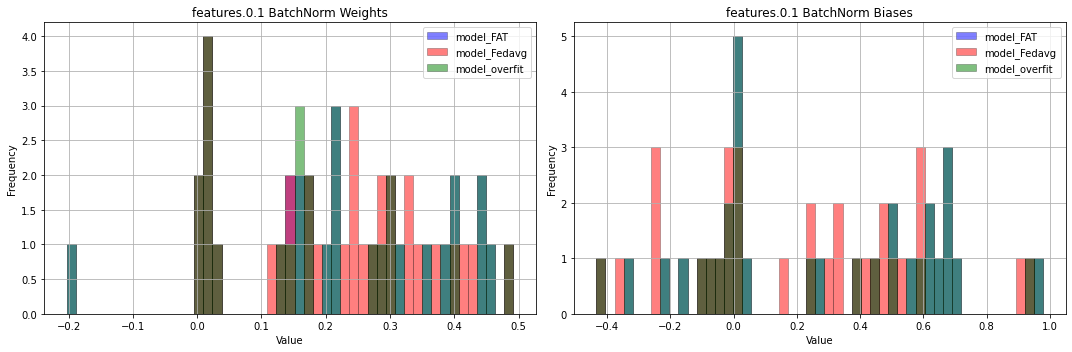

features.0.1 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.466915
features.0.1 - L2 Norm of Weight Difference (FAT vs Overfit): 0.021191
features.0.1 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.463293
features.0.1 - Weight Dimensions: torch.Size([32])
features.0.1 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.676207
features.0.1 - L2 Norm of Bias Difference (FAT vs Overfit): 0.008221
features.0.1 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.672000
features.0.1 - Bias Dimensions: torch.Size([32])


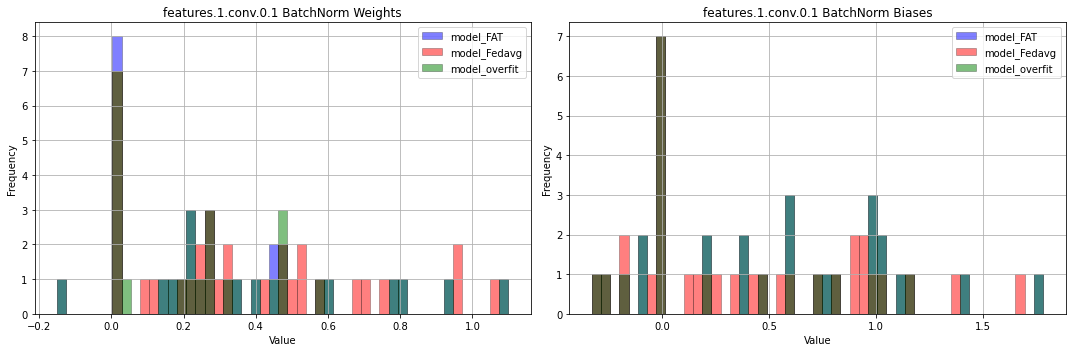

features.1.conv.0.1 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.784787
features.1.conv.0.1 - L2 Norm of Weight Difference (FAT vs Overfit): 0.015068
features.1.conv.0.1 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.782133
features.1.conv.0.1 - Weight Dimensions: torch.Size([32])
features.1.conv.0.1 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.533547
features.1.conv.0.1 - L2 Norm of Bias Difference (FAT vs Overfit): 0.007999
features.1.conv.0.1 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.527475
features.1.conv.0.1 - Bias Dimensions: torch.Size([32])


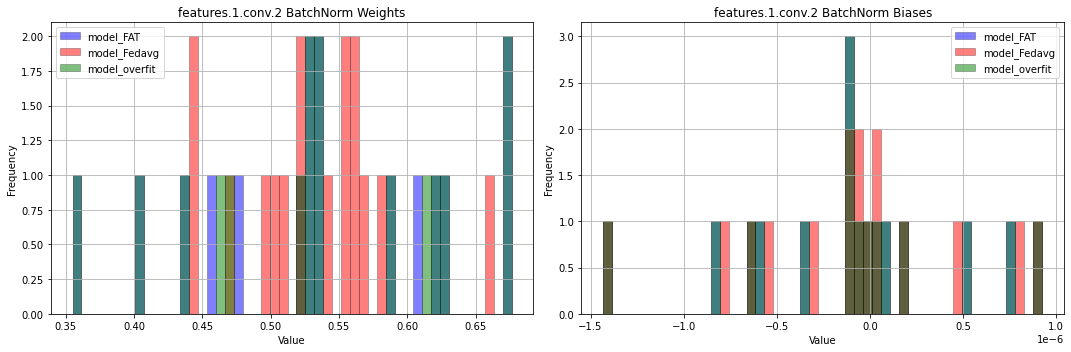

features.1.conv.2 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.227595
features.1.conv.2 - L2 Norm of Weight Difference (FAT vs Overfit): 0.005649
features.1.conv.2 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.226617
features.1.conv.2 - Weight Dimensions: torch.Size([16])
features.1.conv.2 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.000000
features.1.conv.2 - L2 Norm of Bias Difference (FAT vs Overfit): 0.000000
features.1.conv.2 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.000000
features.1.conv.2 - Bias Dimensions: torch.Size([16])


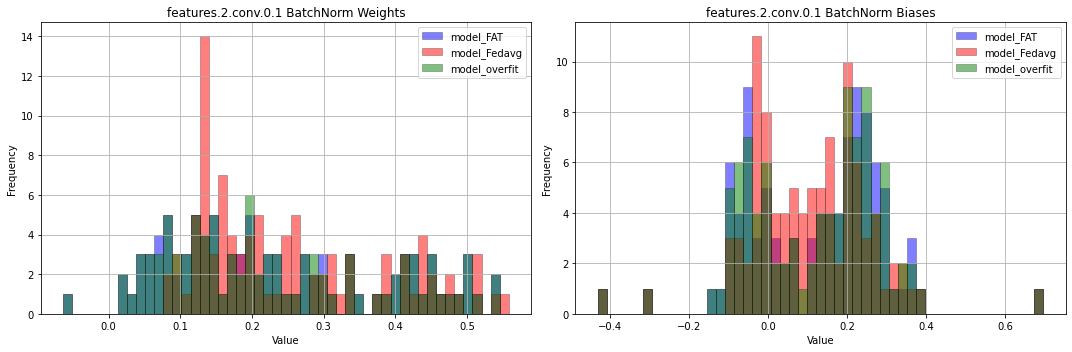

features.2.conv.0.1 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.423860
features.2.conv.0.1 - L2 Norm of Weight Difference (FAT vs Overfit): 0.011770
features.2.conv.0.1 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.416432
features.2.conv.0.1 - Weight Dimensions: torch.Size([96])
features.2.conv.0.1 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.561709
features.2.conv.0.1 - L2 Norm of Bias Difference (FAT vs Overfit): 0.011518
features.2.conv.0.1 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.554557
features.2.conv.0.1 - Bias Dimensions: torch.Size([96])


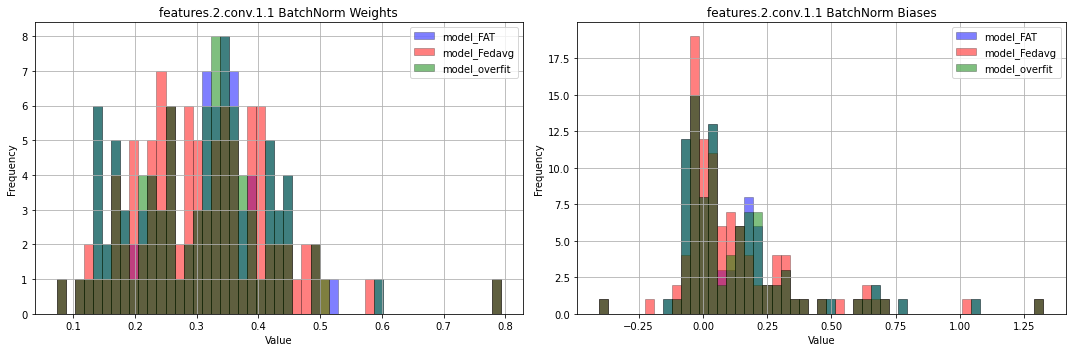

features.2.conv.1.1 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.681929
features.2.conv.1.1 - L2 Norm of Weight Difference (FAT vs Overfit): 0.017304
features.2.conv.1.1 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.673050
features.2.conv.1.1 - Weight Dimensions: torch.Size([96])
features.2.conv.1.1 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.440731
features.2.conv.1.1 - L2 Norm of Bias Difference (FAT vs Overfit): 0.009011
features.2.conv.1.1 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.435676
features.2.conv.1.1 - Bias Dimensions: torch.Size([96])


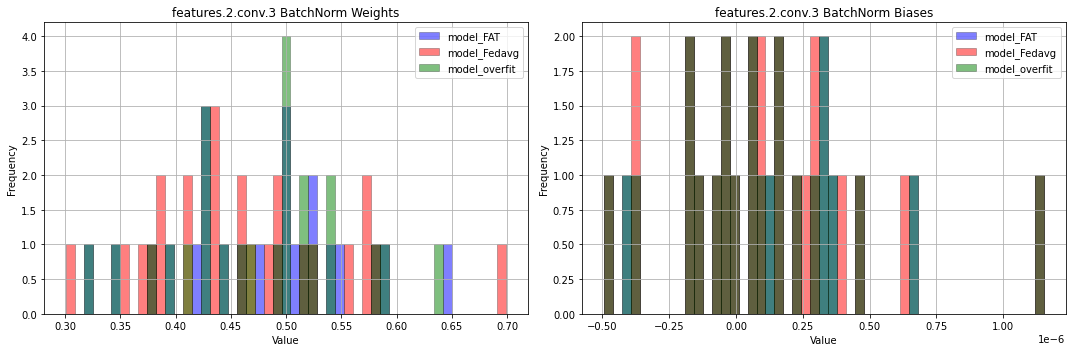

features.2.conv.3 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.285251
features.2.conv.3 - L2 Norm of Weight Difference (FAT vs Overfit): 0.010082
features.2.conv.3 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.277122
features.2.conv.3 - Weight Dimensions: torch.Size([24])
features.2.conv.3 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.000000
features.2.conv.3 - L2 Norm of Bias Difference (FAT vs Overfit): 0.000000
features.2.conv.3 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.000000
features.2.conv.3 - Bias Dimensions: torch.Size([24])


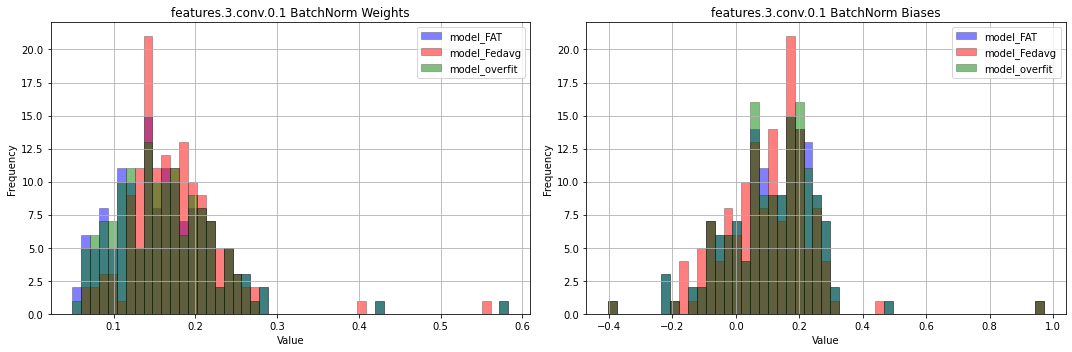

features.3.conv.0.1 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.344666
features.3.conv.0.1 - L2 Norm of Weight Difference (FAT vs Overfit): 0.012581
features.3.conv.0.1 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.335511
features.3.conv.0.1 - Weight Dimensions: torch.Size([144])
features.3.conv.0.1 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.378423
features.3.conv.0.1 - L2 Norm of Bias Difference (FAT vs Overfit): 0.008339
features.3.conv.0.1 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.374583
features.3.conv.0.1 - Bias Dimensions: torch.Size([144])


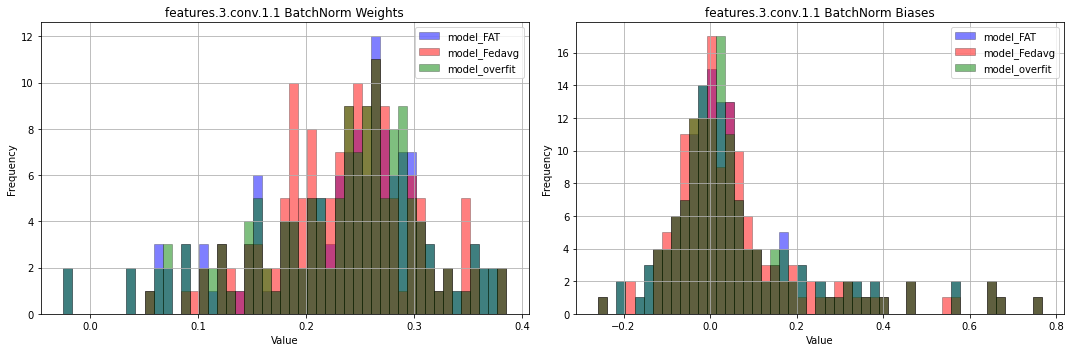

features.3.conv.1.1 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.498880
features.3.conv.1.1 - L2 Norm of Weight Difference (FAT vs Overfit): 0.016004
features.3.conv.1.1 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.489298
features.3.conv.1.1 - Weight Dimensions: torch.Size([144])
features.3.conv.1.1 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.347354
features.3.conv.1.1 - L2 Norm of Bias Difference (FAT vs Overfit): 0.007539
features.3.conv.1.1 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.344177
features.3.conv.1.1 - Bias Dimensions: torch.Size([144])


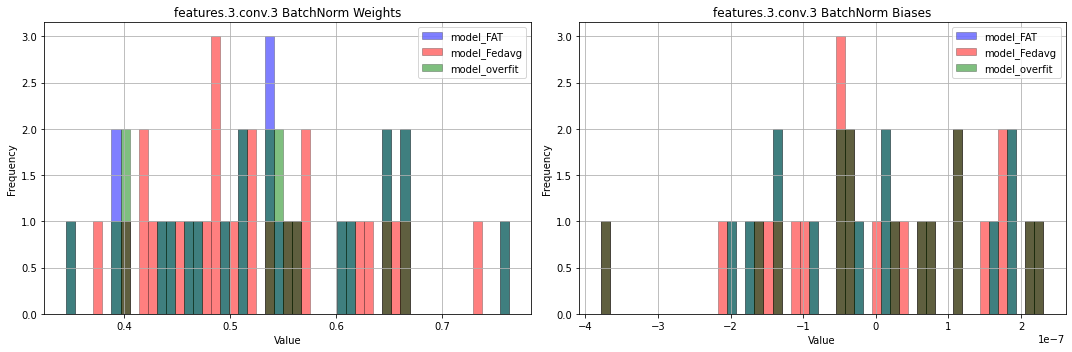

features.3.conv.3 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.156803
features.3.conv.3 - L2 Norm of Weight Difference (FAT vs Overfit): 0.005365
features.3.conv.3 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.154399
features.3.conv.3 - Weight Dimensions: torch.Size([24])
features.3.conv.3 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.000000
features.3.conv.3 - L2 Norm of Bias Difference (FAT vs Overfit): 0.000000
features.3.conv.3 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.000000
features.3.conv.3 - Bias Dimensions: torch.Size([24])


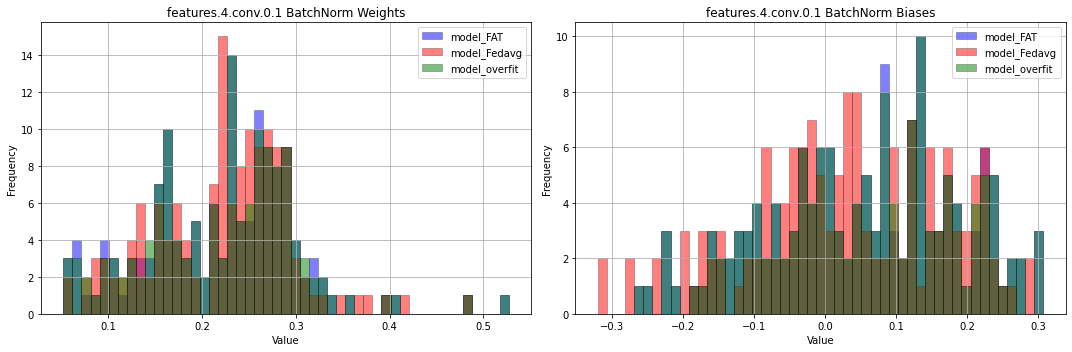

features.4.conv.0.1 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.260717
features.4.conv.0.1 - L2 Norm of Weight Difference (FAT vs Overfit): 0.009292
features.4.conv.0.1 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.257052
features.4.conv.0.1 - Weight Dimensions: torch.Size([144])
features.4.conv.0.1 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.434992
features.4.conv.0.1 - L2 Norm of Bias Difference (FAT vs Overfit): 0.010094
features.4.conv.0.1 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.431550
features.4.conv.0.1 - Bias Dimensions: torch.Size([144])


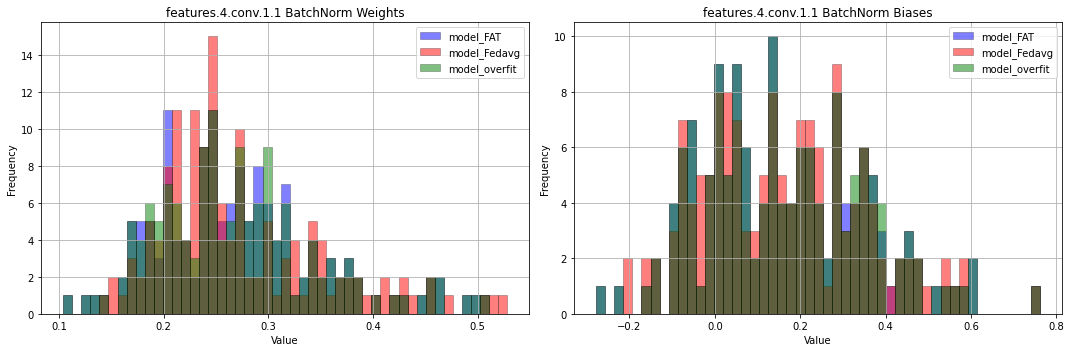

features.4.conv.1.1 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.447309
features.4.conv.1.1 - L2 Norm of Weight Difference (FAT vs Overfit): 0.016615
features.4.conv.1.1 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.439131
features.4.conv.1.1 - Weight Dimensions: torch.Size([144])
features.4.conv.1.1 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.282327
features.4.conv.1.1 - L2 Norm of Bias Difference (FAT vs Overfit): 0.007568
features.4.conv.1.1 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.279133
features.4.conv.1.1 - Bias Dimensions: torch.Size([144])


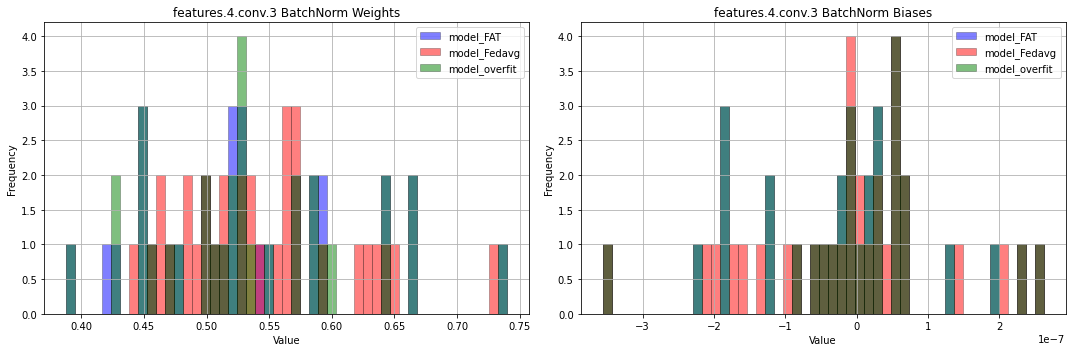

features.4.conv.3 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.192445
features.4.conv.3 - L2 Norm of Weight Difference (FAT vs Overfit): 0.011810
features.4.conv.3 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.186534
features.4.conv.3 - Weight Dimensions: torch.Size([32])
features.4.conv.3 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.000000
features.4.conv.3 - L2 Norm of Bias Difference (FAT vs Overfit): 0.000000
features.4.conv.3 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.000000
features.4.conv.3 - Bias Dimensions: torch.Size([32])


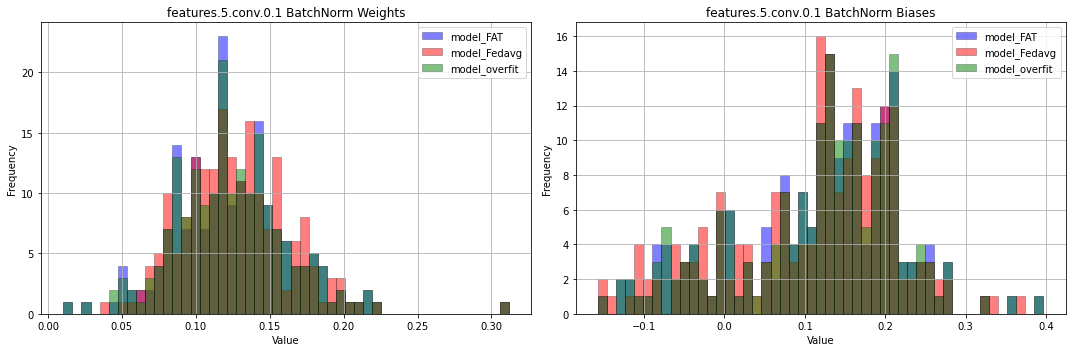

features.5.conv.0.1 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.264635
features.5.conv.0.1 - L2 Norm of Weight Difference (FAT vs Overfit): 0.009814
features.5.conv.0.1 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.262999
features.5.conv.0.1 - Weight Dimensions: torch.Size([192])
features.5.conv.0.1 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.230865
features.5.conv.0.1 - L2 Norm of Bias Difference (FAT vs Overfit): 0.007324
features.5.conv.0.1 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.230494
features.5.conv.0.1 - Bias Dimensions: torch.Size([192])


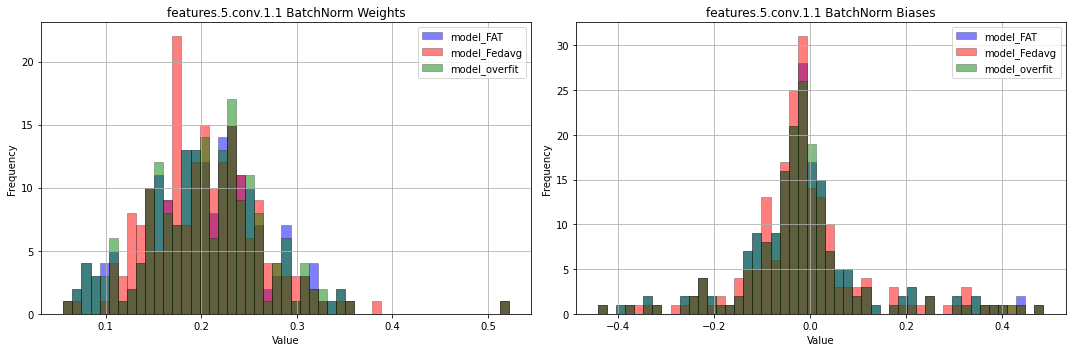

features.5.conv.1.1 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.334344
features.5.conv.1.1 - L2 Norm of Weight Difference (FAT vs Overfit): 0.013198
features.5.conv.1.1 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.330740
features.5.conv.1.1 - Weight Dimensions: torch.Size([192])
features.5.conv.1.1 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.232862
features.5.conv.1.1 - L2 Norm of Bias Difference (FAT vs Overfit): 0.008654
features.5.conv.1.1 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.231131
features.5.conv.1.1 - Bias Dimensions: torch.Size([192])


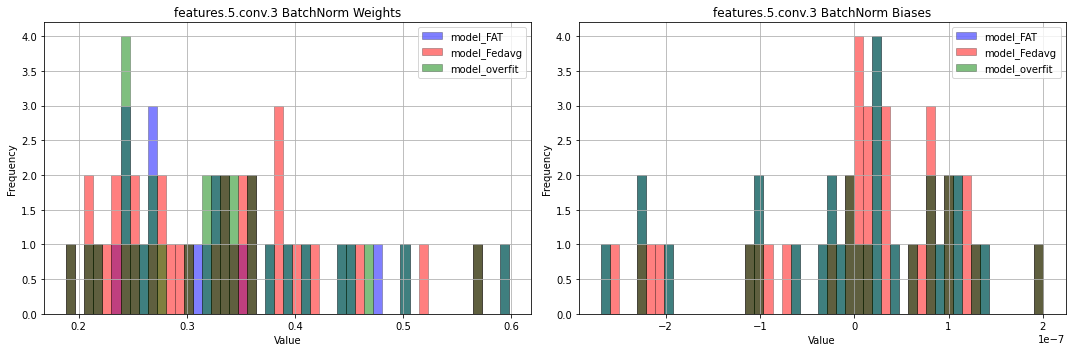

features.5.conv.3 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.160145
features.5.conv.3 - L2 Norm of Weight Difference (FAT vs Overfit): 0.008962
features.5.conv.3 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.159371
features.5.conv.3 - Weight Dimensions: torch.Size([32])
features.5.conv.3 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.000000
features.5.conv.3 - L2 Norm of Bias Difference (FAT vs Overfit): 0.000000
features.5.conv.3 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.000000
features.5.conv.3 - Bias Dimensions: torch.Size([32])


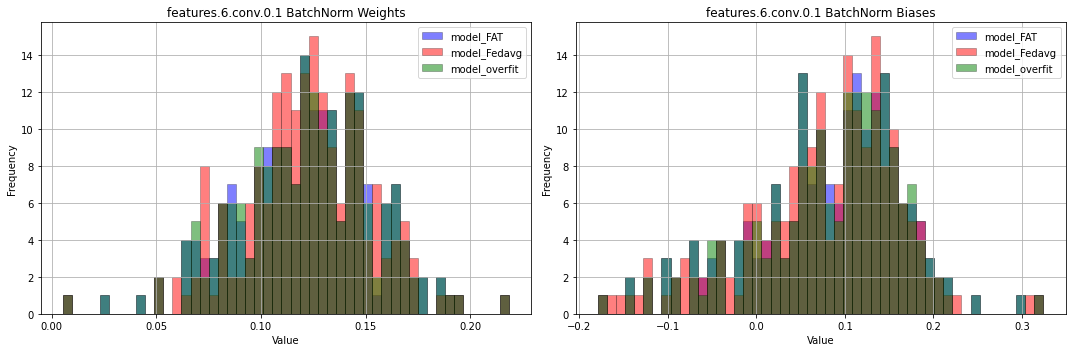

features.6.conv.0.1 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.194224
features.6.conv.0.1 - L2 Norm of Weight Difference (FAT vs Overfit): 0.007814
features.6.conv.0.1 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.192471
features.6.conv.0.1 - Weight Dimensions: torch.Size([192])
features.6.conv.0.1 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.249402
features.6.conv.0.1 - L2 Norm of Bias Difference (FAT vs Overfit): 0.007712
features.6.conv.0.1 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.248658
features.6.conv.0.1 - Bias Dimensions: torch.Size([192])


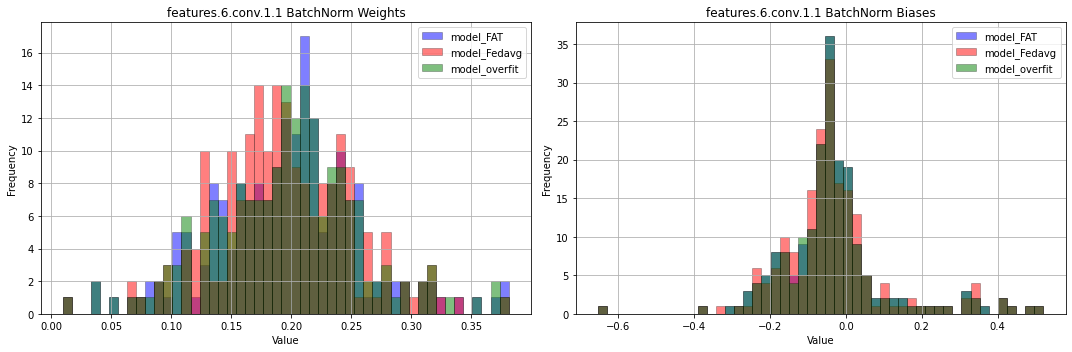

features.6.conv.1.1 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.296168
features.6.conv.1.1 - L2 Norm of Weight Difference (FAT vs Overfit): 0.013079
features.6.conv.1.1 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.293027
features.6.conv.1.1 - Weight Dimensions: torch.Size([192])
features.6.conv.1.1 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.208544
features.6.conv.1.1 - L2 Norm of Bias Difference (FAT vs Overfit): 0.007667
features.6.conv.1.1 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.207605
features.6.conv.1.1 - Bias Dimensions: torch.Size([192])


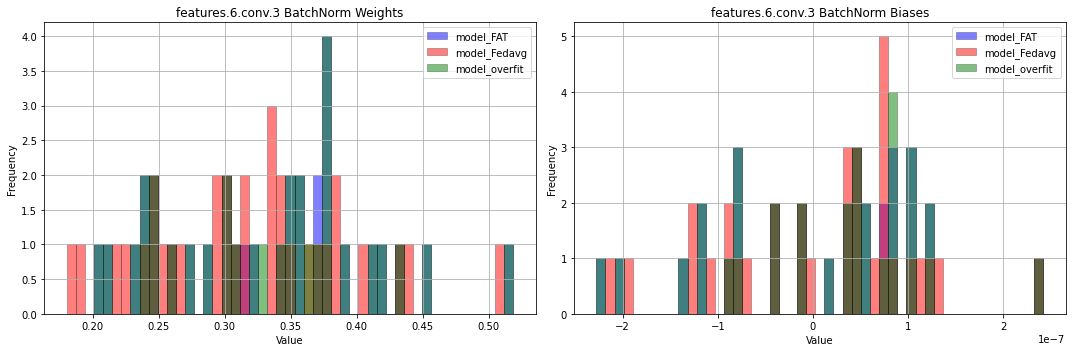

features.6.conv.3 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.141765
features.6.conv.3 - L2 Norm of Weight Difference (FAT vs Overfit): 0.005316
features.6.conv.3 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.141594
features.6.conv.3 - Weight Dimensions: torch.Size([32])
features.6.conv.3 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.000000
features.6.conv.3 - L2 Norm of Bias Difference (FAT vs Overfit): 0.000000
features.6.conv.3 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.000000
features.6.conv.3 - Bias Dimensions: torch.Size([32])


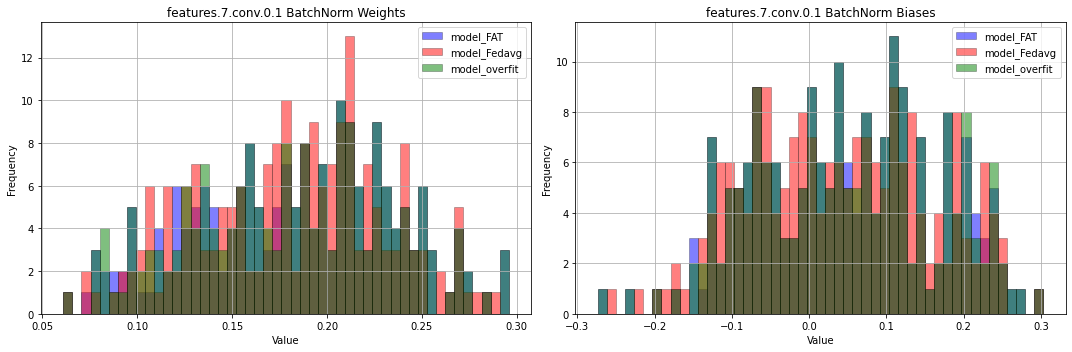

features.7.conv.0.1 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.173645
features.7.conv.0.1 - L2 Norm of Weight Difference (FAT vs Overfit): 0.008900
features.7.conv.0.1 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.171787
features.7.conv.0.1 - Weight Dimensions: torch.Size([192])
features.7.conv.0.1 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.318769
features.7.conv.0.1 - L2 Norm of Bias Difference (FAT vs Overfit): 0.010109
features.7.conv.0.1 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.316801
features.7.conv.0.1 - Bias Dimensions: torch.Size([192])


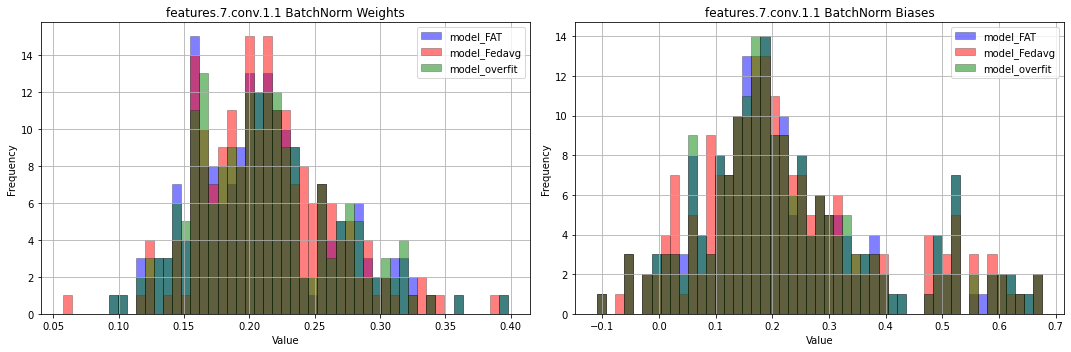

features.7.conv.1.1 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.381406
features.7.conv.1.1 - L2 Norm of Weight Difference (FAT vs Overfit): 0.021017
features.7.conv.1.1 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.374119
features.7.conv.1.1 - Weight Dimensions: torch.Size([192])
features.7.conv.1.1 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.231208
features.7.conv.1.1 - L2 Norm of Bias Difference (FAT vs Overfit): 0.006323
features.7.conv.1.1 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.229317
features.7.conv.1.1 - Bias Dimensions: torch.Size([192])


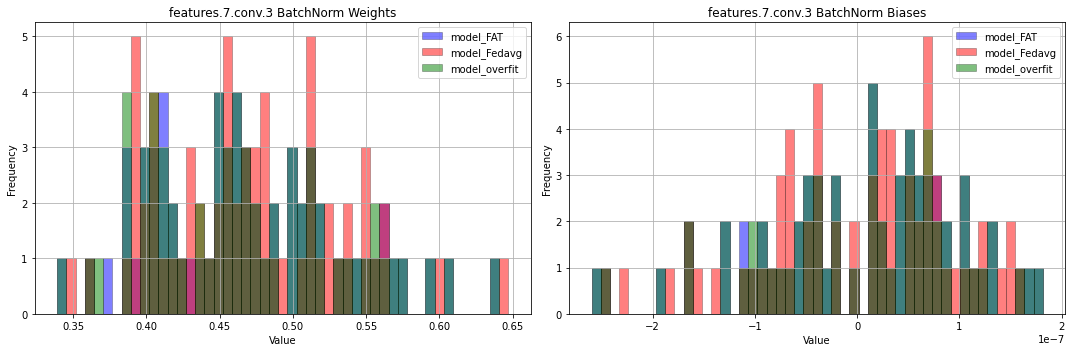

features.7.conv.3 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.177550
features.7.conv.3 - L2 Norm of Weight Difference (FAT vs Overfit): 0.011317
features.7.conv.3 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.175592
features.7.conv.3 - Weight Dimensions: torch.Size([64])
features.7.conv.3 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.000000
features.7.conv.3 - L2 Norm of Bias Difference (FAT vs Overfit): 0.000000
features.7.conv.3 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.000000
features.7.conv.3 - Bias Dimensions: torch.Size([64])


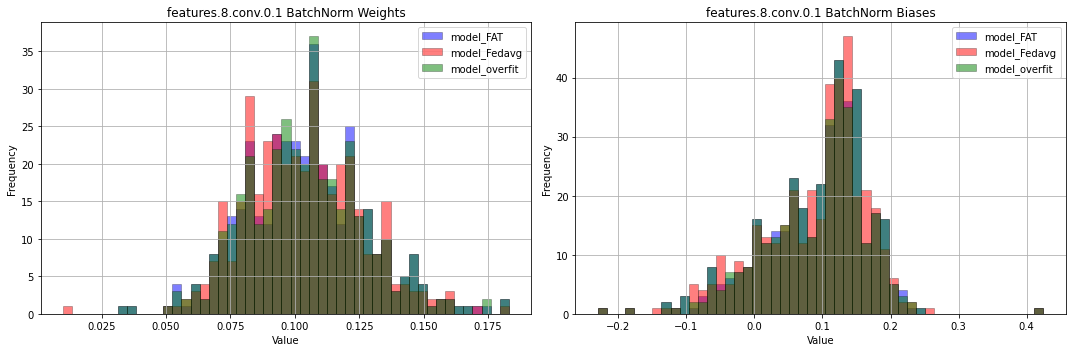

features.8.conv.0.1 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.254361
features.8.conv.0.1 - L2 Norm of Weight Difference (FAT vs Overfit): 0.009462
features.8.conv.0.1 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.253761
features.8.conv.0.1 - Weight Dimensions: torch.Size([384])
features.8.conv.0.1 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.267169
features.8.conv.0.1 - L2 Norm of Bias Difference (FAT vs Overfit): 0.008877
features.8.conv.0.1 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.266635
features.8.conv.0.1 - Bias Dimensions: torch.Size([384])


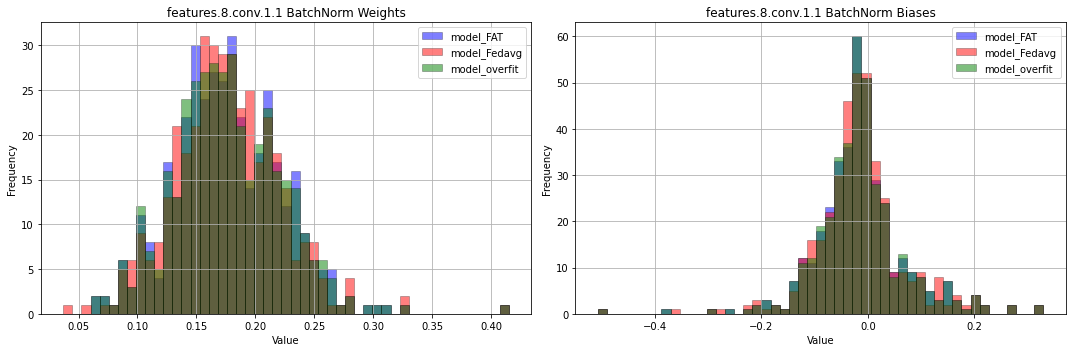

features.8.conv.1.1 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.301307
features.8.conv.1.1 - L2 Norm of Weight Difference (FAT vs Overfit): 0.012678
features.8.conv.1.1 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.299595
features.8.conv.1.1 - Weight Dimensions: torch.Size([384])
features.8.conv.1.1 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.228417
features.8.conv.1.1 - L2 Norm of Bias Difference (FAT vs Overfit): 0.008837
features.8.conv.1.1 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.228209
features.8.conv.1.1 - Bias Dimensions: torch.Size([384])


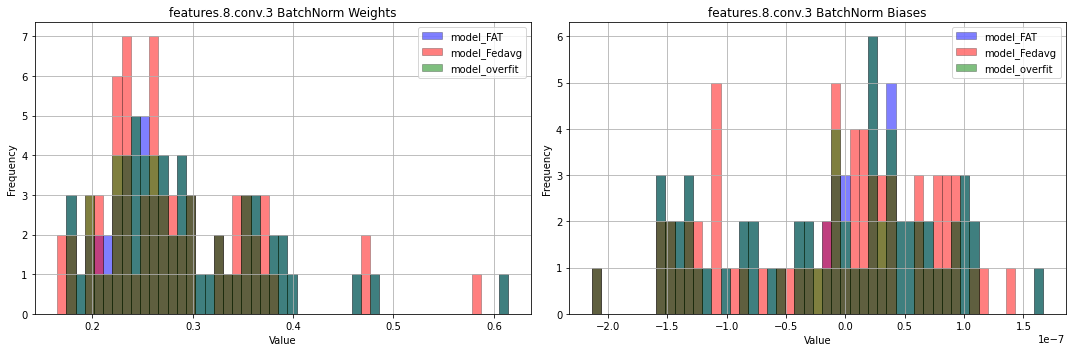

features.8.conv.3 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.147855
features.8.conv.3 - L2 Norm of Weight Difference (FAT vs Overfit): 0.008440
features.8.conv.3 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.145683
features.8.conv.3 - Weight Dimensions: torch.Size([64])
features.8.conv.3 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.000000
features.8.conv.3 - L2 Norm of Bias Difference (FAT vs Overfit): 0.000000
features.8.conv.3 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.000000
features.8.conv.3 - Bias Dimensions: torch.Size([64])


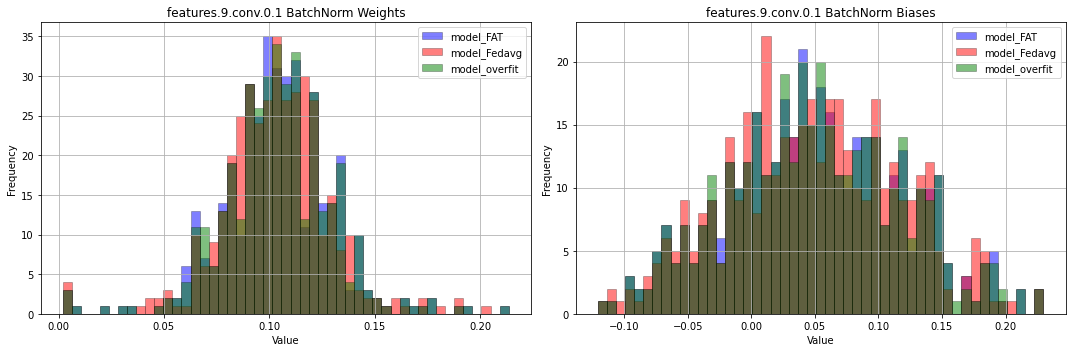

features.9.conv.0.1 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.212843
features.9.conv.0.1 - L2 Norm of Weight Difference (FAT vs Overfit): 0.008162
features.9.conv.0.1 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.212150
features.9.conv.0.1 - Weight Dimensions: torch.Size([384])
features.9.conv.0.1 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.287722
features.9.conv.0.1 - L2 Norm of Bias Difference (FAT vs Overfit): 0.009228
features.9.conv.0.1 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.287372
features.9.conv.0.1 - Bias Dimensions: torch.Size([384])


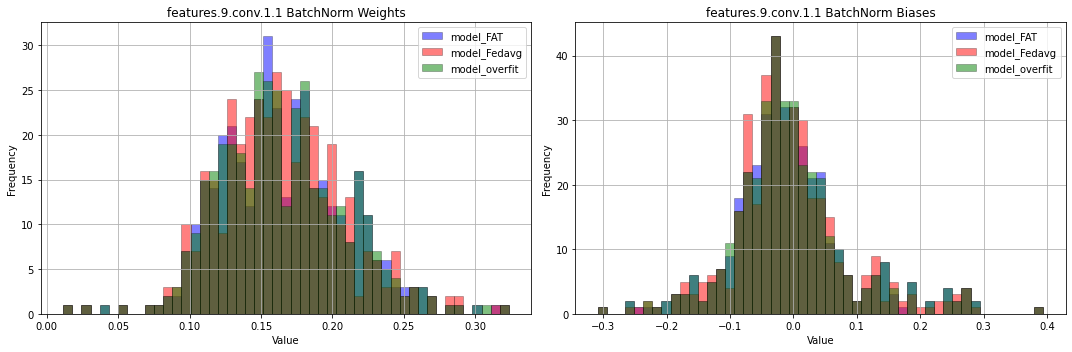

features.9.conv.1.1 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.270850
features.9.conv.1.1 - L2 Norm of Weight Difference (FAT vs Overfit): 0.011119
features.9.conv.1.1 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.269603
features.9.conv.1.1 - Weight Dimensions: torch.Size([384])
features.9.conv.1.1 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.216563
features.9.conv.1.1 - L2 Norm of Bias Difference (FAT vs Overfit): 0.007206
features.9.conv.1.1 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.216252
features.9.conv.1.1 - Bias Dimensions: torch.Size([384])


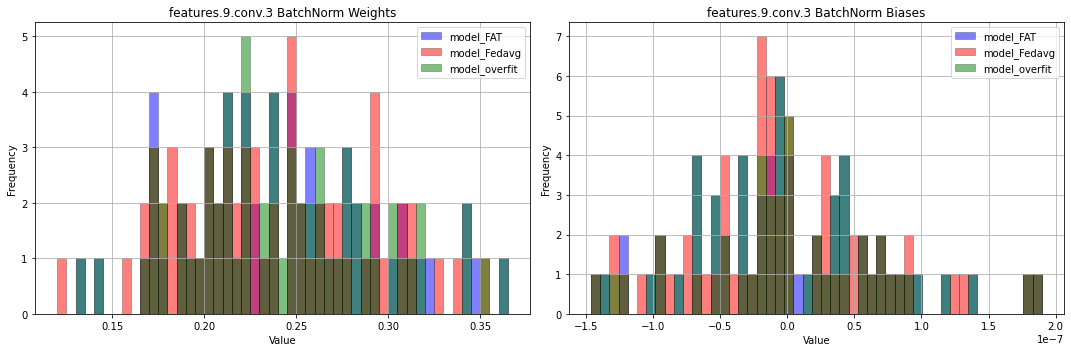

features.9.conv.3 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.151848
features.9.conv.3 - L2 Norm of Weight Difference (FAT vs Overfit): 0.007477
features.9.conv.3 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.150841
features.9.conv.3 - Weight Dimensions: torch.Size([64])
features.9.conv.3 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.000000
features.9.conv.3 - L2 Norm of Bias Difference (FAT vs Overfit): 0.000000
features.9.conv.3 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.000000
features.9.conv.3 - Bias Dimensions: torch.Size([64])


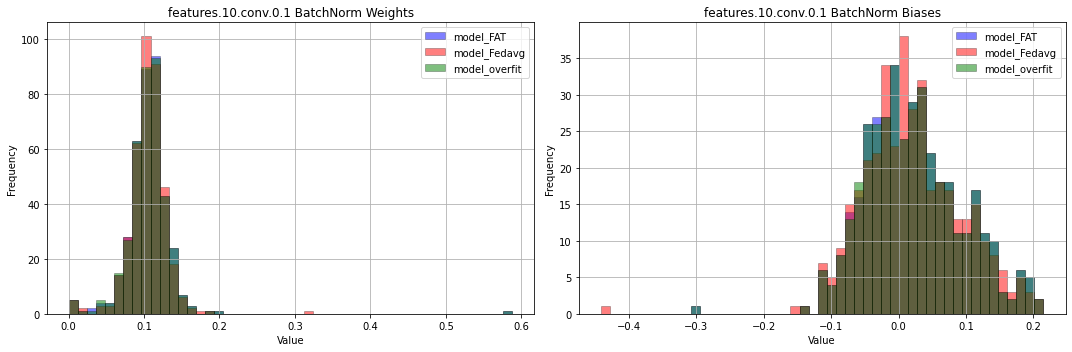

features.10.conv.0.1 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.323922
features.10.conv.0.1 - L2 Norm of Weight Difference (FAT vs Overfit): 0.006285
features.10.conv.0.1 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.323038
features.10.conv.0.1 - Weight Dimensions: torch.Size([384])
features.10.conv.0.1 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.315021
features.10.conv.0.1 - L2 Norm of Bias Difference (FAT vs Overfit): 0.007794
features.10.conv.0.1 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.314320
features.10.conv.0.1 - Bias Dimensions: torch.Size([384])


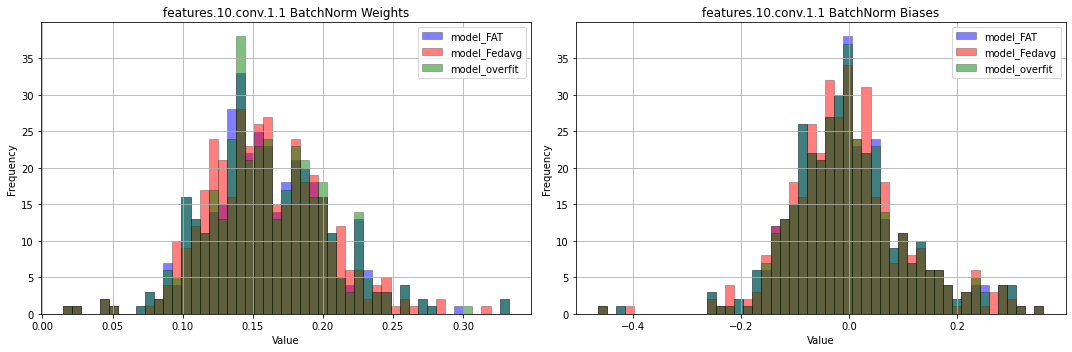

features.10.conv.1.1 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.295065
features.10.conv.1.1 - L2 Norm of Weight Difference (FAT vs Overfit): 0.010947
features.10.conv.1.1 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.292649
features.10.conv.1.1 - Weight Dimensions: torch.Size([384])
features.10.conv.1.1 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.212027
features.10.conv.1.1 - L2 Norm of Bias Difference (FAT vs Overfit): 0.007161
features.10.conv.1.1 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.212481
features.10.conv.1.1 - Bias Dimensions: torch.Size([384])


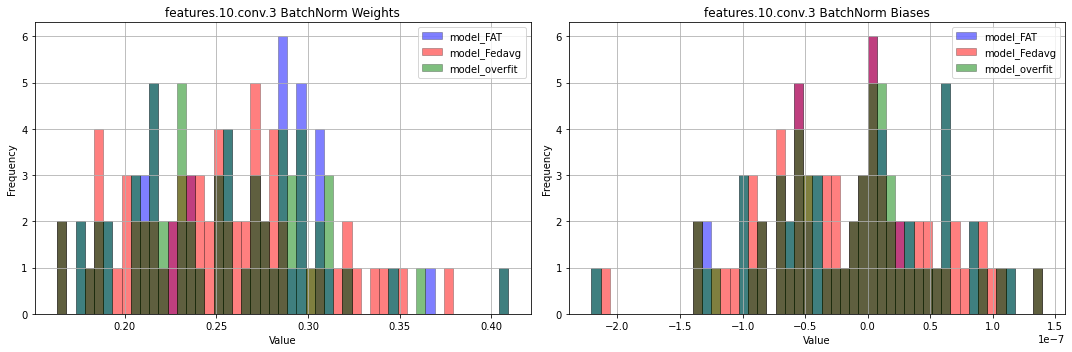

features.10.conv.3 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.145365
features.10.conv.3 - L2 Norm of Weight Difference (FAT vs Overfit): 0.008130
features.10.conv.3 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.145220
features.10.conv.3 - Weight Dimensions: torch.Size([64])
features.10.conv.3 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.000000
features.10.conv.3 - L2 Norm of Bias Difference (FAT vs Overfit): 0.000000
features.10.conv.3 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.000000
features.10.conv.3 - Bias Dimensions: torch.Size([64])


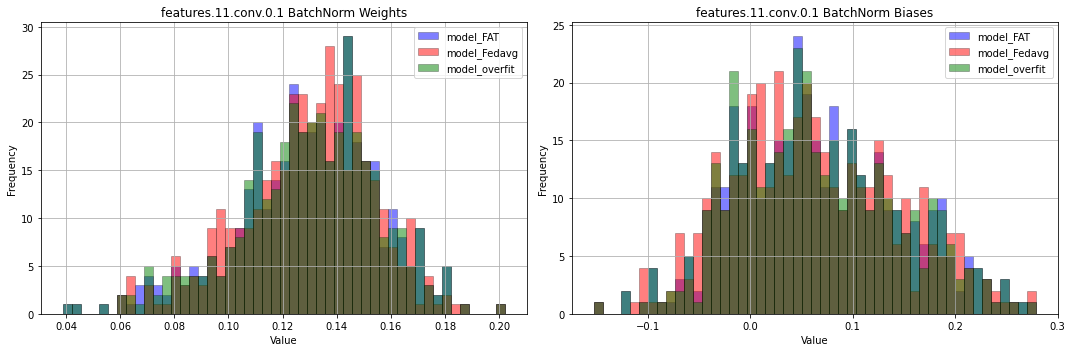

features.11.conv.0.1 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.181997
features.11.conv.0.1 - L2 Norm of Weight Difference (FAT vs Overfit): 0.007644
features.11.conv.0.1 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.182198
features.11.conv.0.1 - Weight Dimensions: torch.Size([384])
features.11.conv.0.1 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.305666
features.11.conv.0.1 - L2 Norm of Bias Difference (FAT vs Overfit): 0.010118
features.11.conv.0.1 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.305253
features.11.conv.0.1 - Bias Dimensions: torch.Size([384])


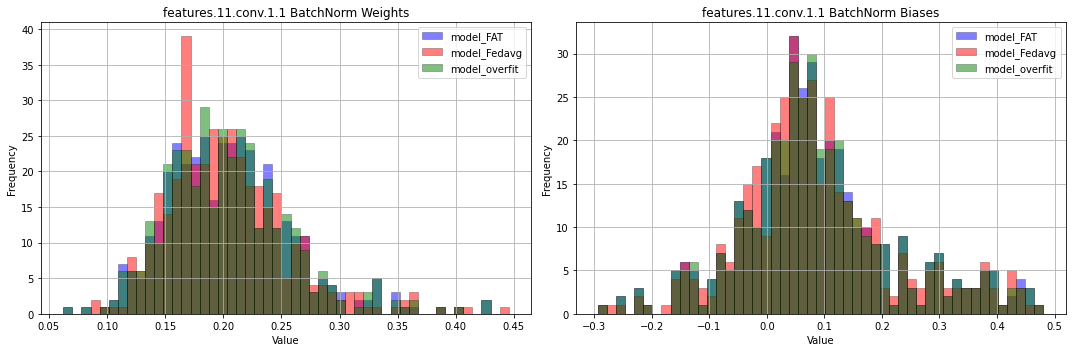

features.11.conv.1.1 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.327698
features.11.conv.1.1 - L2 Norm of Weight Difference (FAT vs Overfit): 0.016129
features.11.conv.1.1 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.324116
features.11.conv.1.1 - Weight Dimensions: torch.Size([384])
features.11.conv.1.1 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.245680
features.11.conv.1.1 - L2 Norm of Bias Difference (FAT vs Overfit): 0.009593
features.11.conv.1.1 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.243732
features.11.conv.1.1 - Bias Dimensions: torch.Size([384])


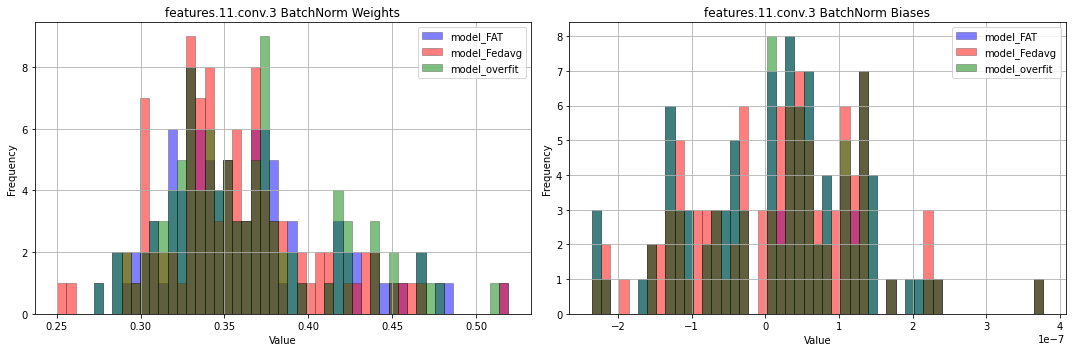

features.11.conv.3 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.173017
features.11.conv.3 - L2 Norm of Weight Difference (FAT vs Overfit): 0.012989
features.11.conv.3 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.170324
features.11.conv.3 - Weight Dimensions: torch.Size([96])
features.11.conv.3 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.000000
features.11.conv.3 - L2 Norm of Bias Difference (FAT vs Overfit): 0.000000
features.11.conv.3 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.000000
features.11.conv.3 - Bias Dimensions: torch.Size([96])


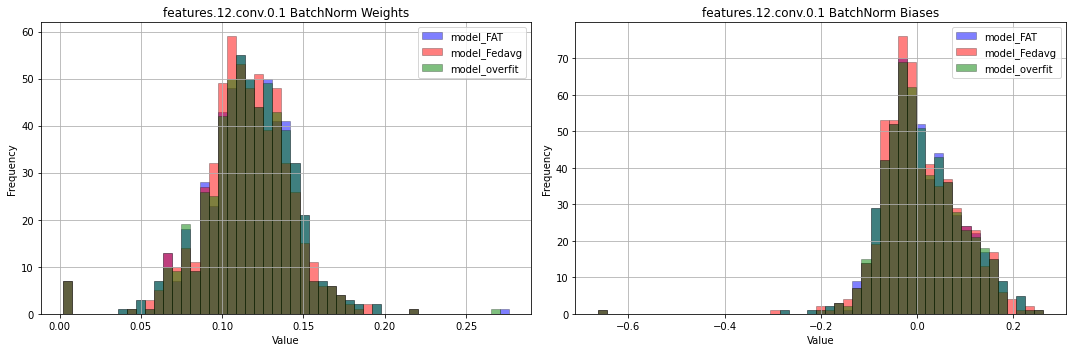

features.12.conv.0.1 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.246724
features.12.conv.0.1 - L2 Norm of Weight Difference (FAT vs Overfit): 0.011476
features.12.conv.0.1 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.242784
features.12.conv.0.1 - Weight Dimensions: torch.Size([576])
features.12.conv.0.1 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.322663
features.12.conv.0.1 - L2 Norm of Bias Difference (FAT vs Overfit): 0.009623
features.12.conv.0.1 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.322986
features.12.conv.0.1 - Bias Dimensions: torch.Size([576])


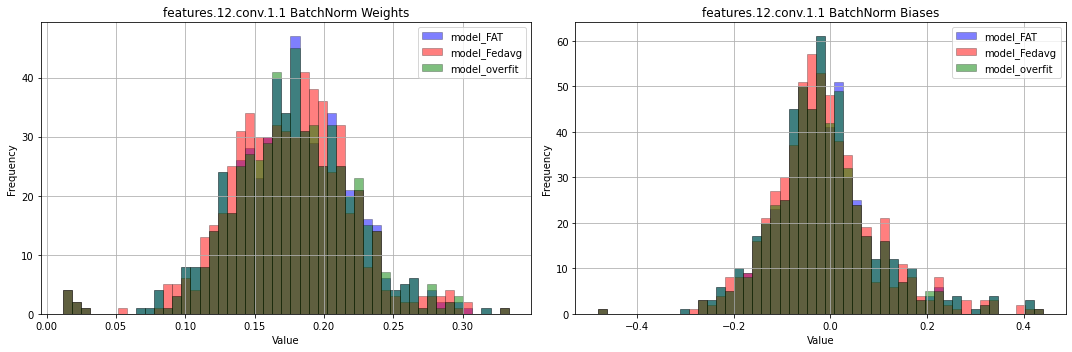

features.12.conv.1.1 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.360116
features.12.conv.1.1 - L2 Norm of Weight Difference (FAT vs Overfit): 0.013387
features.12.conv.1.1 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.358981
features.12.conv.1.1 - Weight Dimensions: torch.Size([576])
features.12.conv.1.1 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.255479
features.12.conv.1.1 - L2 Norm of Bias Difference (FAT vs Overfit): 0.008285
features.12.conv.1.1 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.254954
features.12.conv.1.1 - Bias Dimensions: torch.Size([576])


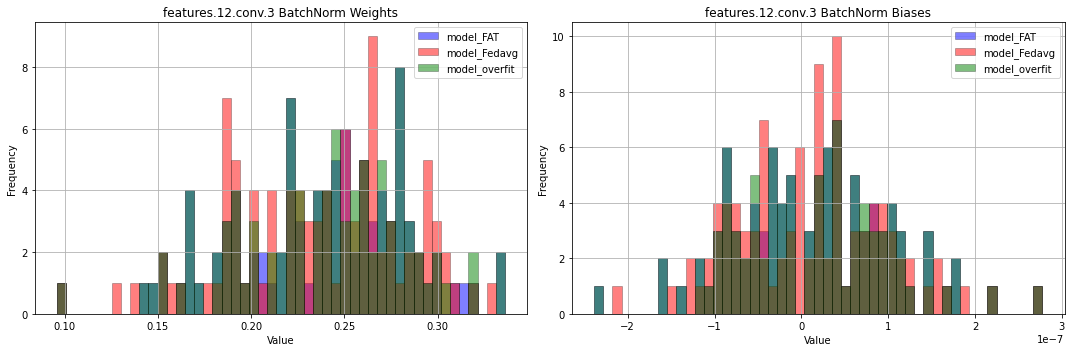

features.12.conv.3 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.205905
features.12.conv.3 - L2 Norm of Weight Difference (FAT vs Overfit): 0.008790
features.12.conv.3 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.204615
features.12.conv.3 - Weight Dimensions: torch.Size([96])
features.12.conv.3 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.000000
features.12.conv.3 - L2 Norm of Bias Difference (FAT vs Overfit): 0.000000
features.12.conv.3 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.000000
features.12.conv.3 - Bias Dimensions: torch.Size([96])


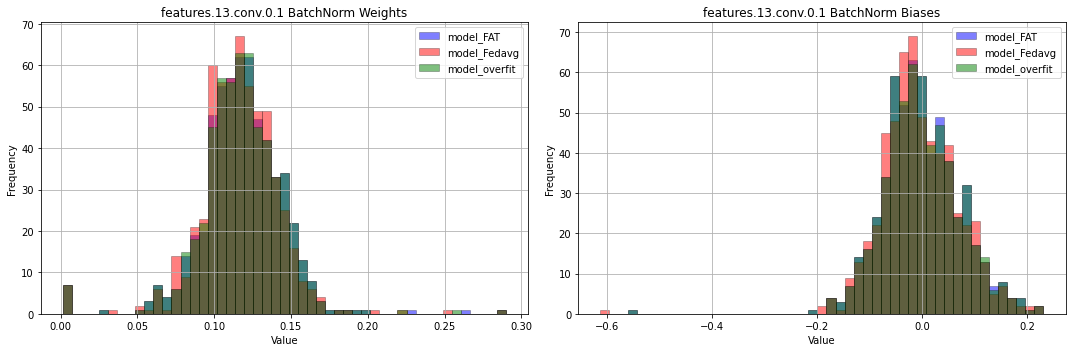

features.13.conv.0.1 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.180504
features.13.conv.0.1 - L2 Norm of Weight Difference (FAT vs Overfit): 0.009663
features.13.conv.0.1 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.179738
features.13.conv.0.1 - Weight Dimensions: torch.Size([576])
features.13.conv.0.1 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.326152
features.13.conv.0.1 - L2 Norm of Bias Difference (FAT vs Overfit): 0.009378
features.13.conv.0.1 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.325078
features.13.conv.0.1 - Bias Dimensions: torch.Size([576])


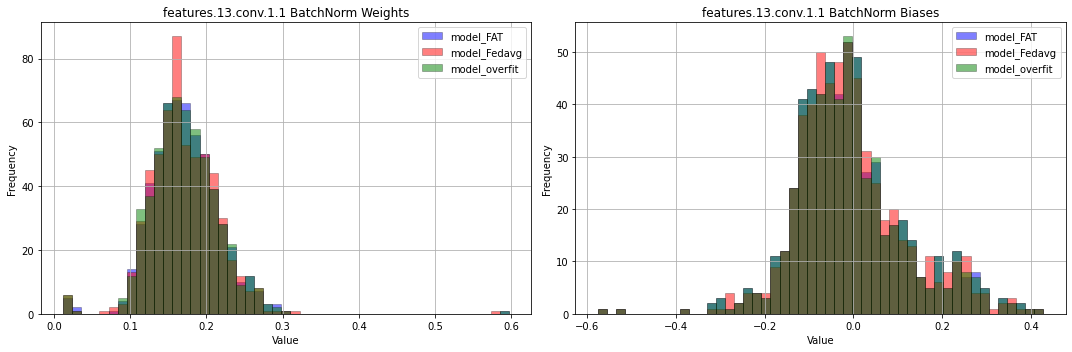

features.13.conv.1.1 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.328770
features.13.conv.1.1 - L2 Norm of Weight Difference (FAT vs Overfit): 0.014548
features.13.conv.1.1 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.327659
features.13.conv.1.1 - Weight Dimensions: torch.Size([576])
features.13.conv.1.1 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.226051
features.13.conv.1.1 - L2 Norm of Bias Difference (FAT vs Overfit): 0.007363
features.13.conv.1.1 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.225815
features.13.conv.1.1 - Bias Dimensions: torch.Size([576])


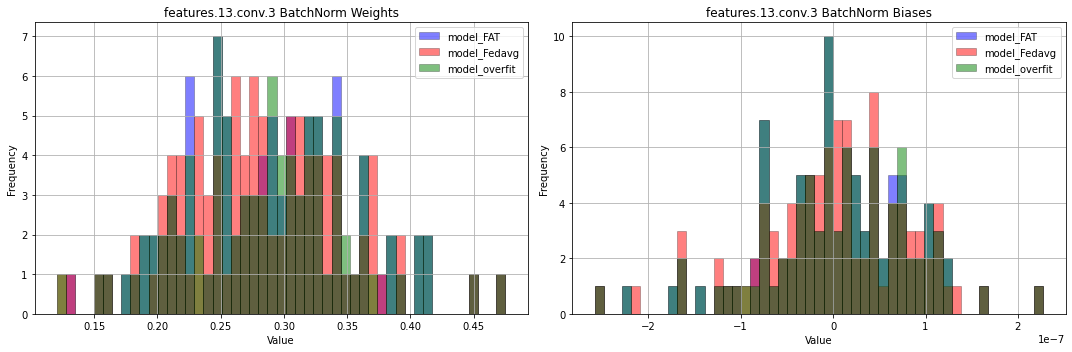

features.13.conv.3 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.184309
features.13.conv.3 - L2 Norm of Weight Difference (FAT vs Overfit): 0.006588
features.13.conv.3 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.184978
features.13.conv.3 - Weight Dimensions: torch.Size([96])
features.13.conv.3 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.000000
features.13.conv.3 - L2 Norm of Bias Difference (FAT vs Overfit): 0.000000
features.13.conv.3 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.000000
features.13.conv.3 - Bias Dimensions: torch.Size([96])


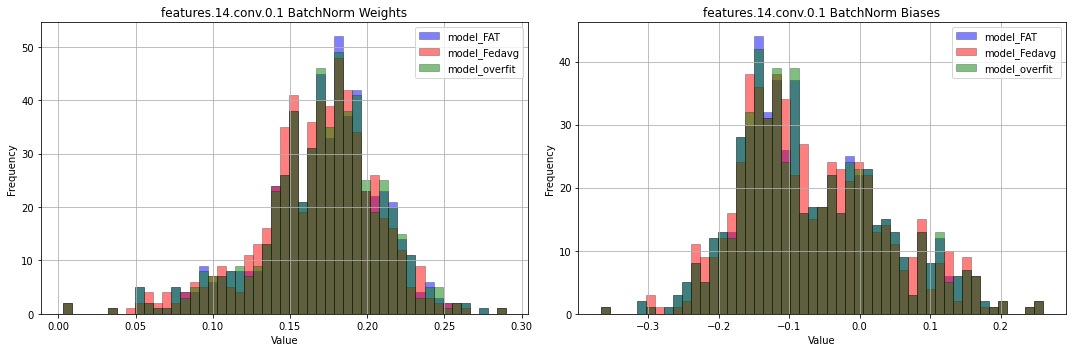

features.14.conv.0.1 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.221363
features.14.conv.0.1 - L2 Norm of Weight Difference (FAT vs Overfit): 0.007002
features.14.conv.0.1 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.221122
features.14.conv.0.1 - Weight Dimensions: torch.Size([576])
features.14.conv.0.1 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.323541
features.14.conv.0.1 - L2 Norm of Bias Difference (FAT vs Overfit): 0.008870
features.14.conv.0.1 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.323435
features.14.conv.0.1 - Bias Dimensions: torch.Size([576])


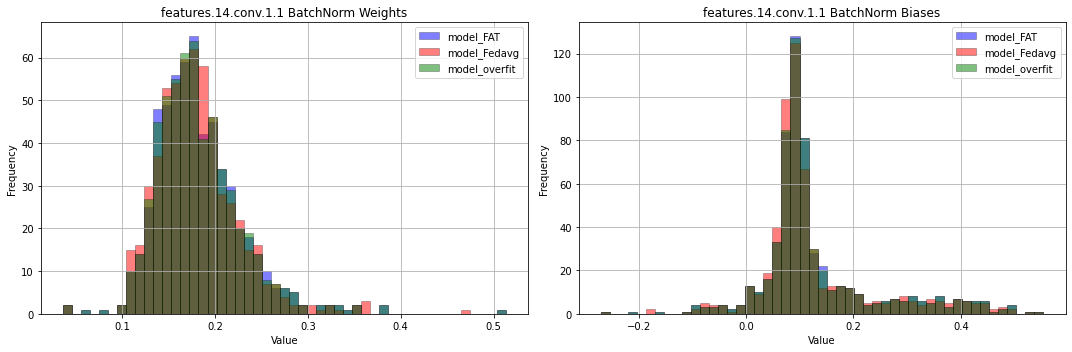

features.14.conv.1.1 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.341478
features.14.conv.1.1 - L2 Norm of Weight Difference (FAT vs Overfit): 0.016750
features.14.conv.1.1 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.339642
features.14.conv.1.1 - Weight Dimensions: torch.Size([576])
features.14.conv.1.1 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.220144
features.14.conv.1.1 - L2 Norm of Bias Difference (FAT vs Overfit): 0.007892
features.14.conv.1.1 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.218912
features.14.conv.1.1 - Bias Dimensions: torch.Size([576])


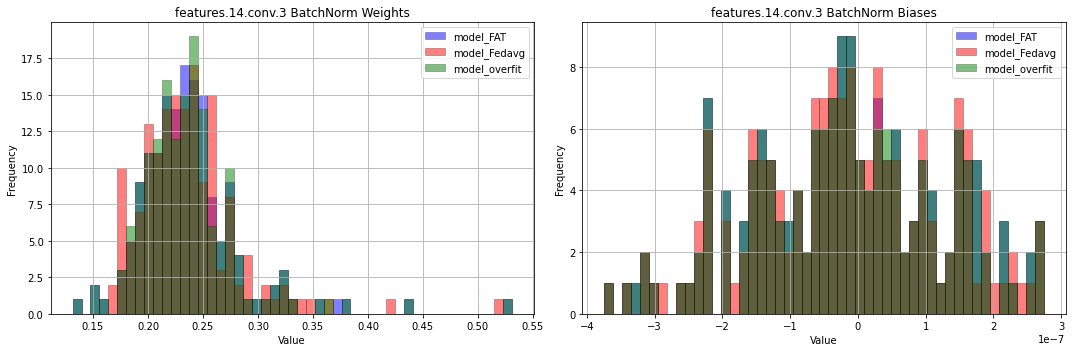

features.14.conv.3 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.233819
features.14.conv.3 - L2 Norm of Weight Difference (FAT vs Overfit): 0.015889
features.14.conv.3 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.230716
features.14.conv.3 - Weight Dimensions: torch.Size([160])
features.14.conv.3 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.000000
features.14.conv.3 - L2 Norm of Bias Difference (FAT vs Overfit): 0.000000
features.14.conv.3 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.000000
features.14.conv.3 - Bias Dimensions: torch.Size([160])


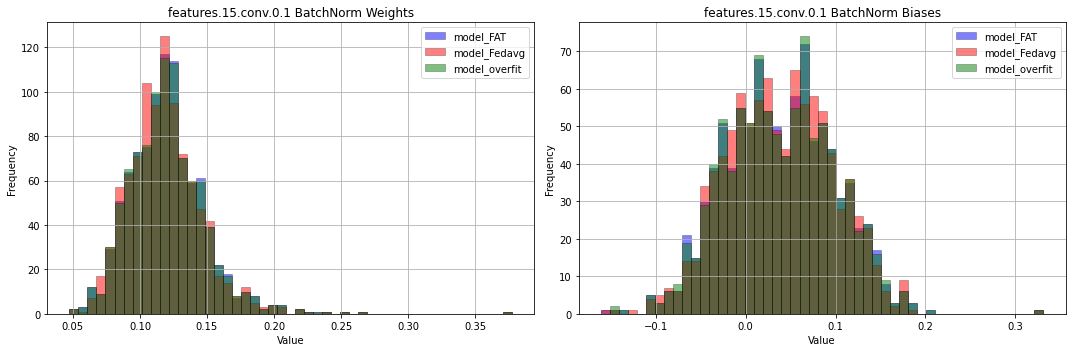

features.15.conv.0.1 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.168548
features.15.conv.0.1 - L2 Norm of Weight Difference (FAT vs Overfit): 0.006633
features.15.conv.0.1 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.168347
features.15.conv.0.1 - Weight Dimensions: torch.Size([960])
features.15.conv.0.1 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.254364
features.15.conv.0.1 - L2 Norm of Bias Difference (FAT vs Overfit): 0.008130
features.15.conv.0.1 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.254141
features.15.conv.0.1 - Bias Dimensions: torch.Size([960])


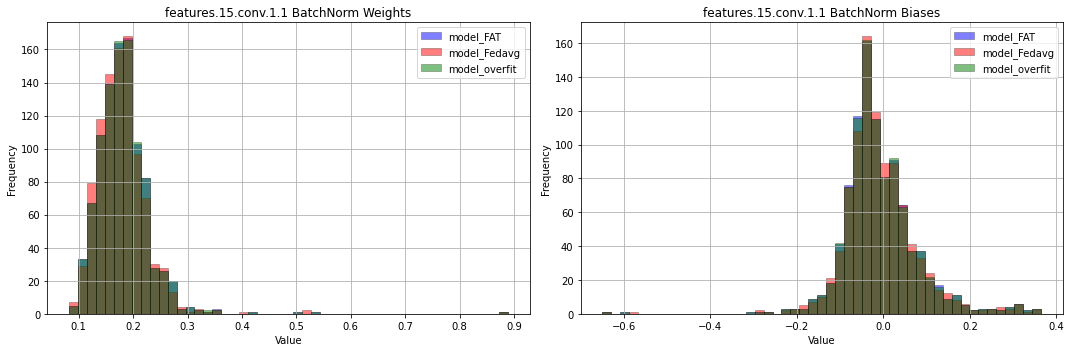

features.15.conv.1.1 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.245787
features.15.conv.1.1 - L2 Norm of Weight Difference (FAT vs Overfit): 0.011442
features.15.conv.1.1 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.245053
features.15.conv.1.1 - Weight Dimensions: torch.Size([960])
features.15.conv.1.1 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.206115
features.15.conv.1.1 - L2 Norm of Bias Difference (FAT vs Overfit): 0.008394
features.15.conv.1.1 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.205507
features.15.conv.1.1 - Bias Dimensions: torch.Size([960])


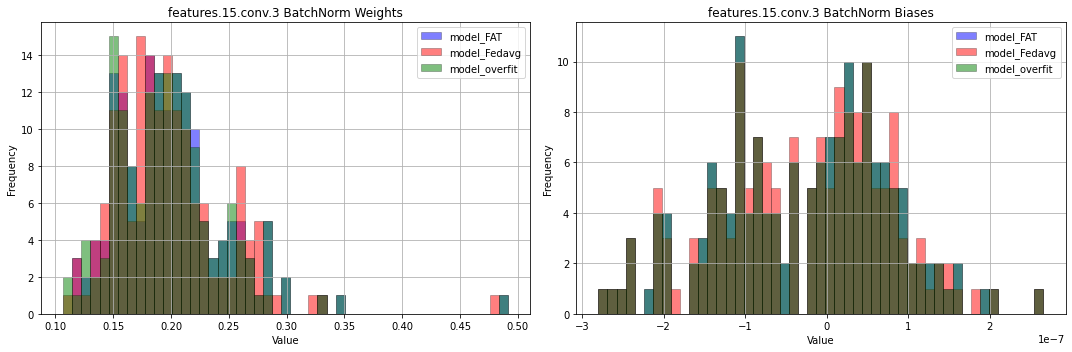

features.15.conv.3 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.185927
features.15.conv.3 - L2 Norm of Weight Difference (FAT vs Overfit): 0.012124
features.15.conv.3 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.186751
features.15.conv.3 - Weight Dimensions: torch.Size([160])
features.15.conv.3 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.000000
features.15.conv.3 - L2 Norm of Bias Difference (FAT vs Overfit): 0.000000
features.15.conv.3 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.000000
features.15.conv.3 - Bias Dimensions: torch.Size([160])


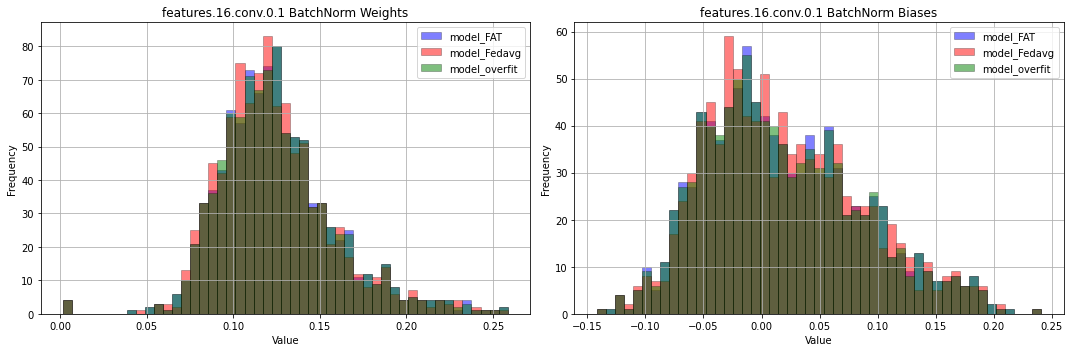

features.16.conv.0.1 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.154740
features.16.conv.0.1 - L2 Norm of Weight Difference (FAT vs Overfit): 0.006616
features.16.conv.0.1 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.154073
features.16.conv.0.1 - Weight Dimensions: torch.Size([960])
features.16.conv.0.1 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.246906
features.16.conv.0.1 - L2 Norm of Bias Difference (FAT vs Overfit): 0.009730
features.16.conv.0.1 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.244915
features.16.conv.0.1 - Bias Dimensions: torch.Size([960])


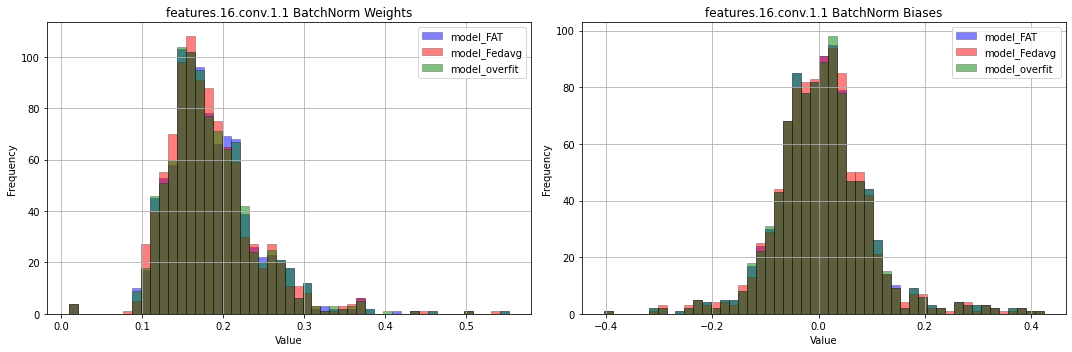

features.16.conv.1.1 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.233866
features.16.conv.1.1 - L2 Norm of Weight Difference (FAT vs Overfit): 0.017362
features.16.conv.1.1 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.229422
features.16.conv.1.1 - Weight Dimensions: torch.Size([960])
features.16.conv.1.1 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.189370
features.16.conv.1.1 - L2 Norm of Bias Difference (FAT vs Overfit): 0.009212
features.16.conv.1.1 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.188557
features.16.conv.1.1 - Bias Dimensions: torch.Size([960])


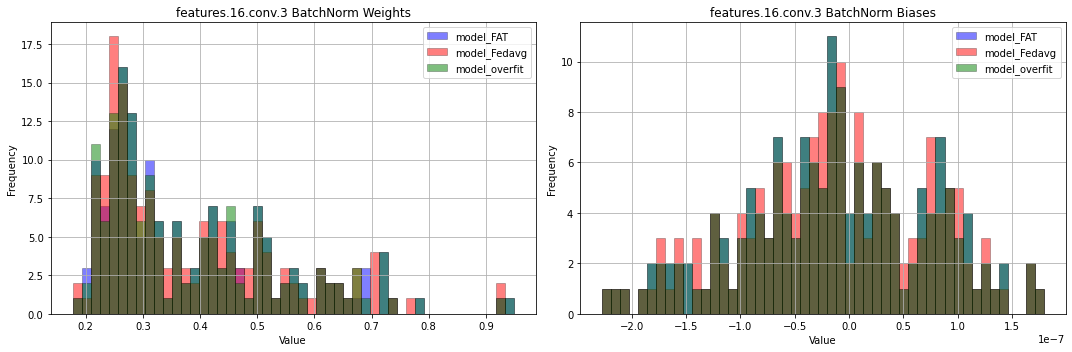

features.16.conv.3 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.116230
features.16.conv.3 - L2 Norm of Weight Difference (FAT vs Overfit): 0.006870
features.16.conv.3 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.114648
features.16.conv.3 - Weight Dimensions: torch.Size([160])
features.16.conv.3 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.000000
features.16.conv.3 - L2 Norm of Bias Difference (FAT vs Overfit): 0.000000
features.16.conv.3 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.000000
features.16.conv.3 - Bias Dimensions: torch.Size([160])


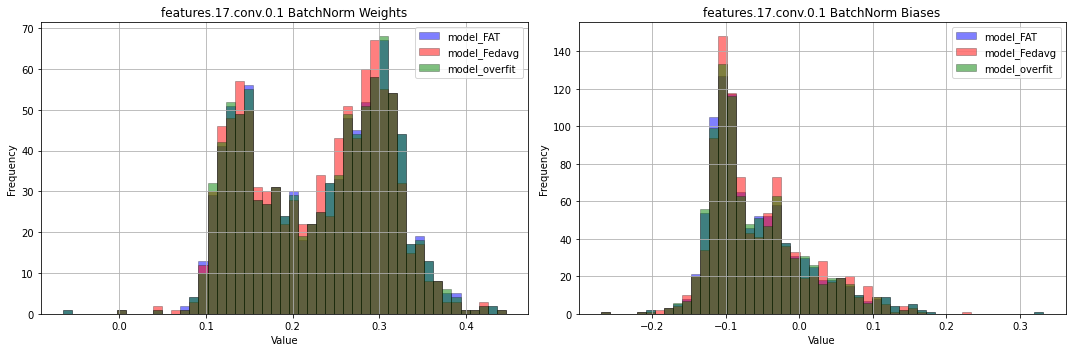

features.17.conv.0.1 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.250351
features.17.conv.0.1 - L2 Norm of Weight Difference (FAT vs Overfit): 0.017721
features.17.conv.0.1 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.245960
features.17.conv.0.1 - Weight Dimensions: torch.Size([960])
features.17.conv.0.1 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.397416
features.17.conv.0.1 - L2 Norm of Bias Difference (FAT vs Overfit): 0.030116
features.17.conv.0.1 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.396809
features.17.conv.0.1 - Bias Dimensions: torch.Size([960])


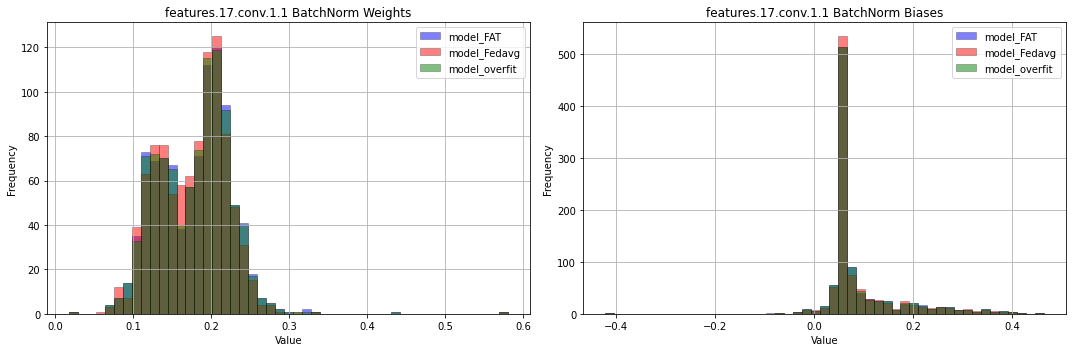

features.17.conv.1.1 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.426228
features.17.conv.1.1 - L2 Norm of Weight Difference (FAT vs Overfit): 0.034369
features.17.conv.1.1 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.410054
features.17.conv.1.1 - Weight Dimensions: torch.Size([960])
features.17.conv.1.1 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.208452
features.17.conv.1.1 - L2 Norm of Bias Difference (FAT vs Overfit): 0.018882
features.17.conv.1.1 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.205573
features.17.conv.1.1 - Bias Dimensions: torch.Size([960])


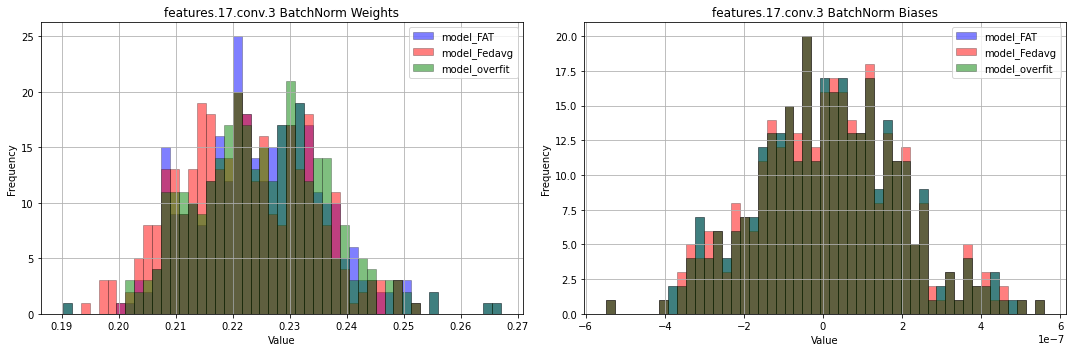

features.17.conv.3 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.215847
features.17.conv.3 - L2 Norm of Weight Difference (FAT vs Overfit): 0.016252
features.17.conv.3 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.208515
features.17.conv.3 - Weight Dimensions: torch.Size([320])
features.17.conv.3 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.000000
features.17.conv.3 - L2 Norm of Bias Difference (FAT vs Overfit): 0.000000
features.17.conv.3 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.000000
features.17.conv.3 - Bias Dimensions: torch.Size([320])


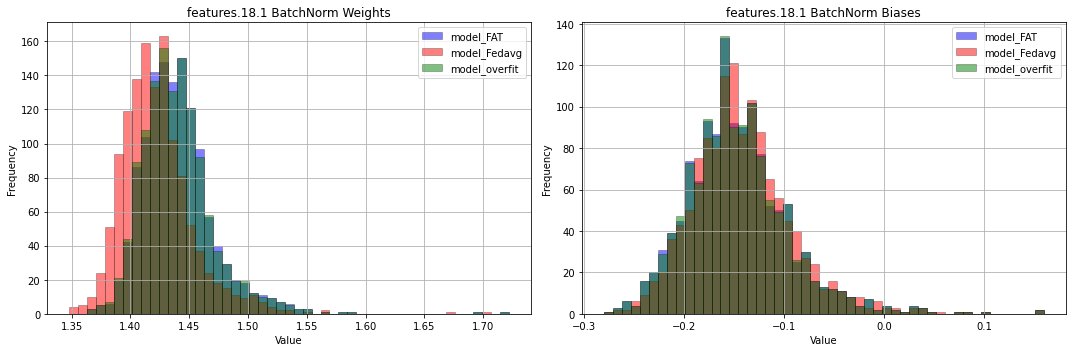

features.18.1 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.635561
features.18.1 - L2 Norm of Weight Difference (FAT vs Overfit): 0.020578
features.18.1 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.615049
features.18.1 - Weight Dimensions: torch.Size([1280])
features.18.1 - L2 Norm of Bias Difference (FAT vs Fedavg): 0.182967
features.18.1 - L2 Norm of Bias Difference (FAT vs Overfit): 0.005339
features.18.1 - L2 Norm of Bias Difference (Fedavg vs Overfit): 0.177951
features.18.1 - Bias Dimensions: torch.Size([1280])


In [7]:
# Toggle options for which models to plot
show_FAT = True
show_Fedavg = True
show_Overfit = True

def get_submodule_by_name(model, name):
    submodule = model
    for part in name.split('.'):
        submodule = getattr(submodule, part)
    return submodule

for name, module in model_FAT.named_modules():
    if isinstance(module, torch.nn.BatchNorm2d):
        # Extract parameters for model_FAT
        bn_weights_FAT = module.weight.data.cpu().numpy().flatten()
        bn_biases_FAT = module.bias.data.cpu().numpy().flatten()

        # Extract parameters for model_Fedavg
        module_Fedavg = get_submodule_by_name(model_Fedavg, name)
        bn_weights_Fedavg = module_Fedavg.weight.data.cpu().numpy().flatten()
        bn_biases_Fedavg = module_Fedavg.bias.data.cpu().numpy().flatten()

        # Extract parameters for model_overfit
        module_overfit = get_submodule_by_name(model_overfit, name)
        bn_weights_overfit = module_overfit.weight.data.cpu().numpy().flatten()
        bn_biases_overfit = module_overfit.bias.data.cpu().numpy().flatten()

        # Compute common bin edges for all models' data
        bn_weights_min = min(np.min(bn_weights_FAT), np.min(bn_weights_Fedavg), np.min(bn_weights_overfit))
        bn_weights_max = max(np.max(bn_weights_FAT), np.max(bn_weights_Fedavg), np.max(bn_weights_overfit))
        bn_biases_min = min(np.min(bn_biases_FAT), np.min(bn_biases_Fedavg), np.min(bn_biases_overfit))
        bn_biases_max = max(np.max(bn_biases_FAT), np.max(bn_biases_Fedavg), np.max(bn_biases_overfit))
        bins_weights = np.linspace(bn_weights_min, bn_weights_max, 50)
        bins_biases = np.linspace(bn_biases_min, bn_biases_max, 50)

        # Plot histograms with toggle options
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        if show_FAT:
            plt.hist(bn_weights_FAT, bins=bins_weights, color='blue', alpha=0.5, label='model_FAT', edgecolor='black', linewidth=0.5)
        if show_Fedavg:
            plt.hist(bn_weights_Fedavg, bins=bins_weights, color='red', alpha=0.5, label='model_Fedavg', edgecolor='black', linewidth=0.5)
        if show_Overfit:
            plt.hist(bn_weights_overfit, bins=bins_weights, color='green', alpha=0.5, label='model_overfit', edgecolor='black', linewidth=0.5)
        plt.title(f'{name} BatchNorm Weights')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        if show_FAT:
            plt.hist(bn_biases_FAT, bins=bins_biases, color='blue', alpha=0.5, label='model_FAT', edgecolor='black', linewidth=0.5)
        if show_Fedavg:
            plt.hist(bn_biases_Fedavg, bins=bins_biases, color='red', alpha=0.5, label='model_Fedavg', edgecolor='black', linewidth=0.5)
        if show_Overfit:
            plt.hist(bn_biases_overfit, bins=bins_biases, color='green', alpha=0.5, label='model_overfit', edgecolor='black', linewidth=0.5)
        plt.title(f'{name} BatchNorm Biases')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Compute L2 norms of differences
        weight_diff_norm_FAT_Fedavg = np.linalg.norm(bn_weights_FAT - bn_weights_Fedavg)
        bias_diff_norm_FAT_Fedavg = np.linalg.norm(bn_biases_FAT - bn_biases_Fedavg)

        weight_diff_norm_FAT_Overfit = np.linalg.norm(bn_weights_FAT - bn_weights_overfit)
        bias_diff_norm_FAT_Overfit = np.linalg.norm(bn_biases_FAT - bn_biases_overfit)

        weight_diff_norm_Fedavg_Overfit = np.linalg.norm(bn_weights_Fedavg - bn_weights_overfit)
        bias_diff_norm_Fedavg_Overfit = np.linalg.norm(bn_biases_Fedavg - bn_biases_overfit)

        # Print differences and dimensions
        print(f"{name} - L2 Norm of Weight Difference (FAT vs Fedavg): {weight_diff_norm_FAT_Fedavg:.6f}")
        print(f"{name} - L2 Norm of Weight Difference (FAT vs Overfit): {weight_diff_norm_FAT_Overfit:.6f}")
        print(f"{name} - L2 Norm of Weight Difference (Fedavg vs Overfit): {weight_diff_norm_Fedavg_Overfit:.6f}")
        print(f"{name} - Weight Dimensions: {module.weight.data.size()}")

        print(f"{name} - L2 Norm of Bias Difference (FAT vs Fedavg): {bias_diff_norm_FAT_Fedavg:.6f}")
        print(f"{name} - L2 Norm of Bias Difference (FAT vs Overfit): {bias_diff_norm_FAT_Overfit:.6f}")
        print(f"{name} - L2 Norm of Bias Difference (Fedavg vs Overfit): {bias_diff_norm_Fedavg_Overfit:.6f}")
        print(f"{name} - Bias Dimensions: {module.bias.data.size()}")


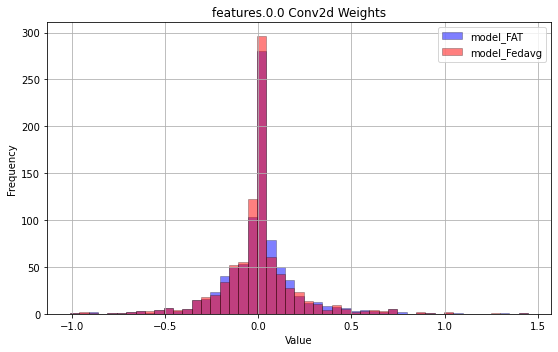

features.0.0 - L2 Norm of Weight Difference (FAT vs Fedavg): 1.103769
features.0.0 - L2 Norm of Weight Difference (FAT vs Overfit): 0.021885
features.0.0 - L2 Norm of Weight Difference (Fedavg vs Overfit): 1.094339
features.0.0 - Weight Dimensions: torch.Size([32, 3, 3, 3])


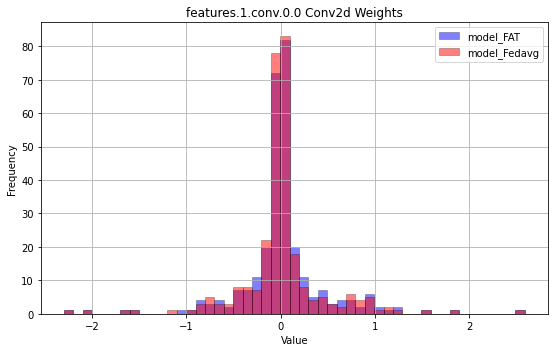

features.1.conv.0.0 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.861393
features.1.conv.0.0 - L2 Norm of Weight Difference (FAT vs Overfit): 0.026412
features.1.conv.0.0 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.851239
features.1.conv.0.0 - Weight Dimensions: torch.Size([32, 1, 3, 3])


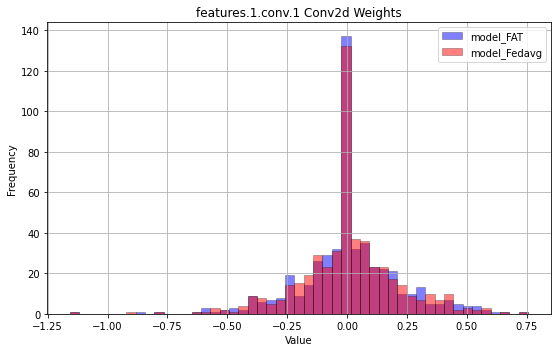

features.1.conv.1 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.737943
features.1.conv.1 - L2 Norm of Weight Difference (FAT vs Overfit): 0.018207
features.1.conv.1 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.730067
features.1.conv.1 - Weight Dimensions: torch.Size([16, 32, 1, 1])


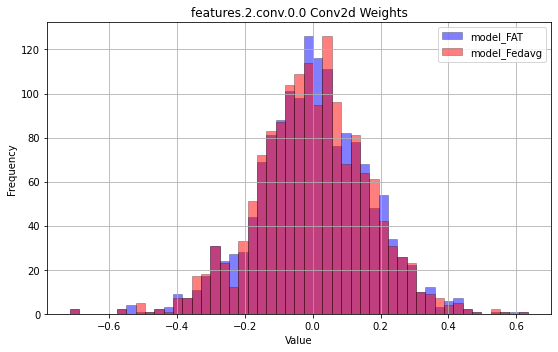

features.2.conv.0.0 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.921957
features.2.conv.0.0 - L2 Norm of Weight Difference (FAT vs Overfit): 0.019165
features.2.conv.0.0 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.917142
features.2.conv.0.0 - Weight Dimensions: torch.Size([96, 16, 1, 1])


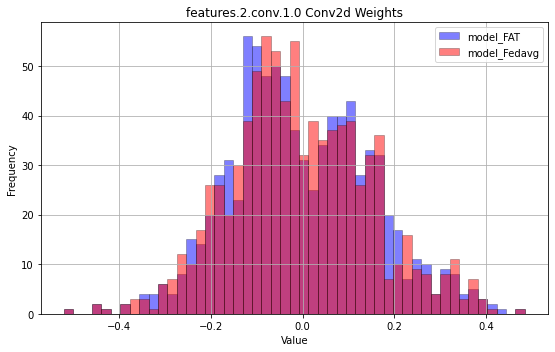

features.2.conv.1.0 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.779759
features.2.conv.1.0 - L2 Norm of Weight Difference (FAT vs Overfit): 0.015041
features.2.conv.1.0 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.775878
features.2.conv.1.0 - Weight Dimensions: torch.Size([96, 1, 3, 3])


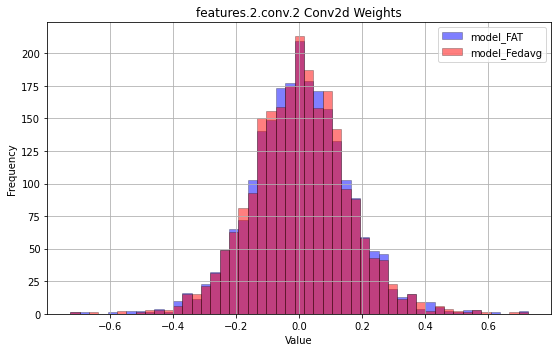

features.2.conv.2 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.954460
features.2.conv.2 - L2 Norm of Weight Difference (FAT vs Overfit): 0.021016
features.2.conv.2 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.949248
features.2.conv.2 - Weight Dimensions: torch.Size([24, 96, 1, 1])


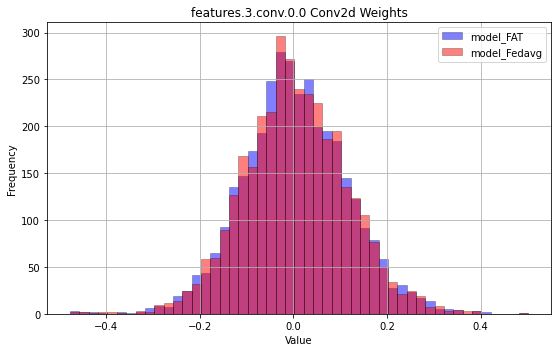

features.3.conv.0.0 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.936512
features.3.conv.0.0 - L2 Norm of Weight Difference (FAT vs Overfit): 0.021173
features.3.conv.0.0 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.932923
features.3.conv.0.0 - Weight Dimensions: torch.Size([144, 24, 1, 1])


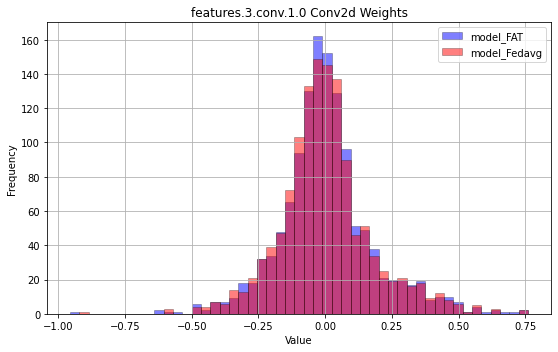

features.3.conv.1.0 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.750134
features.3.conv.1.0 - L2 Norm of Weight Difference (FAT vs Overfit): 0.021395
features.3.conv.1.0 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.741958
features.3.conv.1.0 - Weight Dimensions: torch.Size([144, 1, 3, 3])


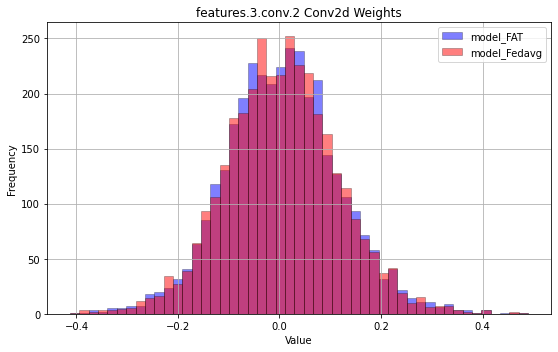

features.3.conv.2 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.831407
features.3.conv.2 - L2 Norm of Weight Difference (FAT vs Overfit): 0.020741
features.3.conv.2 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.827431
features.3.conv.2 - Weight Dimensions: torch.Size([24, 144, 1, 1])


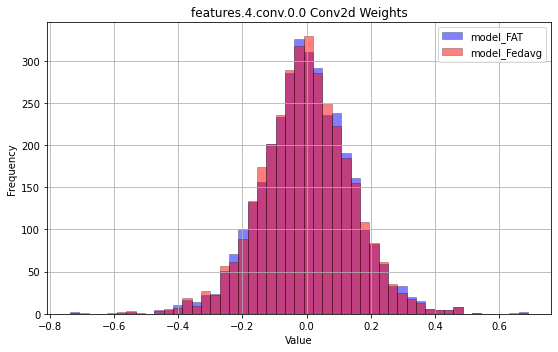

features.4.conv.0.0 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.952165
features.4.conv.0.0 - L2 Norm of Weight Difference (FAT vs Overfit): 0.027937
features.4.conv.0.0 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.947872
features.4.conv.0.0 - Weight Dimensions: torch.Size([144, 24, 1, 1])


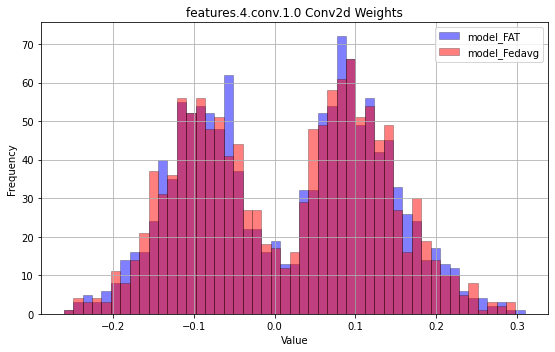

features.4.conv.1.0 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.655567
features.4.conv.1.0 - L2 Norm of Weight Difference (FAT vs Overfit): 0.017860
features.4.conv.1.0 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.656688
features.4.conv.1.0 - Weight Dimensions: torch.Size([144, 1, 3, 3])


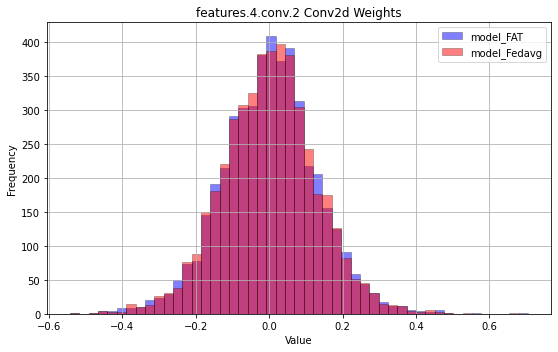

features.4.conv.2 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.881859
features.4.conv.2 - L2 Norm of Weight Difference (FAT vs Overfit): 0.030382
features.4.conv.2 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.877570
features.4.conv.2 - Weight Dimensions: torch.Size([32, 144, 1, 1])


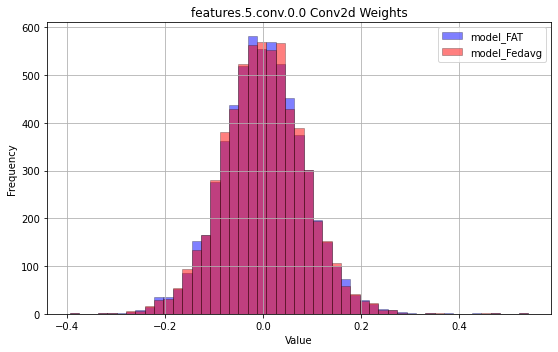

features.5.conv.0.0 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.958055
features.5.conv.0.0 - L2 Norm of Weight Difference (FAT vs Overfit): 0.026607
features.5.conv.0.0 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.958151
features.5.conv.0.0 - Weight Dimensions: torch.Size([192, 32, 1, 1])


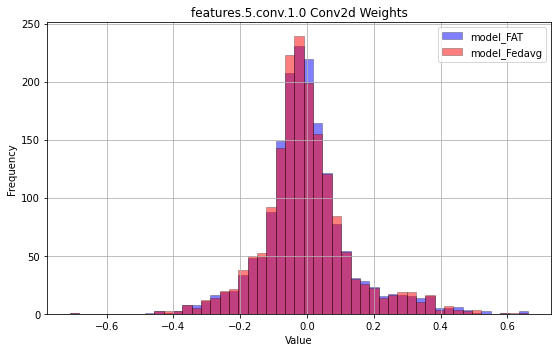

features.5.conv.1.0 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.606801
features.5.conv.1.0 - L2 Norm of Weight Difference (FAT vs Overfit): 0.021148
features.5.conv.1.0 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.604113
features.5.conv.1.0 - Weight Dimensions: torch.Size([192, 1, 3, 3])


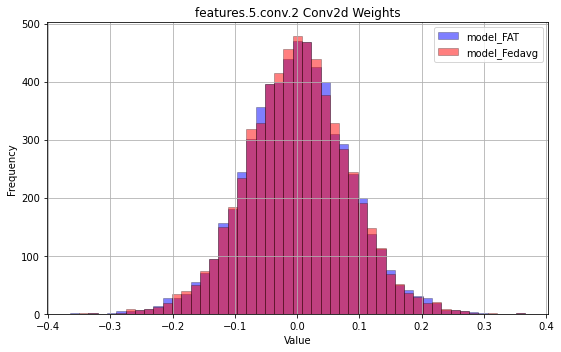

features.5.conv.2 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.808525
features.5.conv.2 - L2 Norm of Weight Difference (FAT vs Overfit): 0.026674
features.5.conv.2 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.807919
features.5.conv.2 - Weight Dimensions: torch.Size([32, 192, 1, 1])


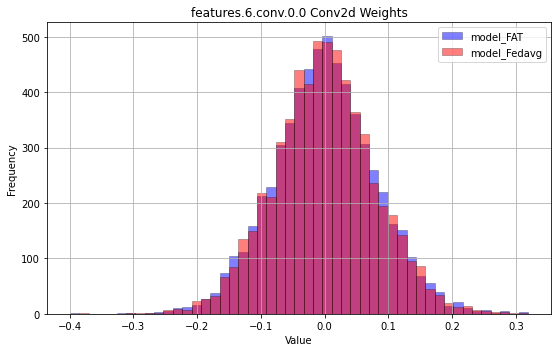

features.6.conv.0.0 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.978802
features.6.conv.0.0 - L2 Norm of Weight Difference (FAT vs Overfit): 0.028211
features.6.conv.0.0 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.978183
features.6.conv.0.0 - Weight Dimensions: torch.Size([192, 32, 1, 1])


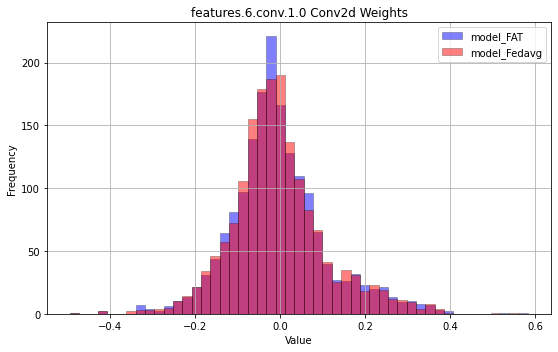

features.6.conv.1.0 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.598030
features.6.conv.1.0 - L2 Norm of Weight Difference (FAT vs Overfit): 0.020128
features.6.conv.1.0 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.597891
features.6.conv.1.0 - Weight Dimensions: torch.Size([192, 1, 3, 3])


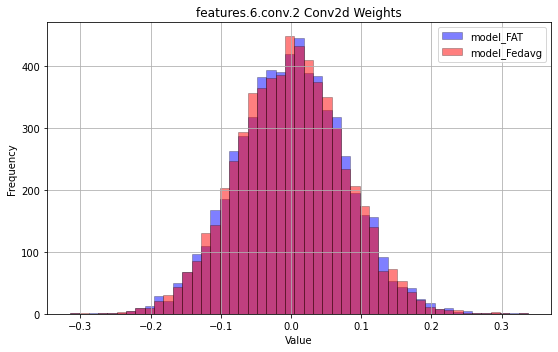

features.6.conv.2 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.824941
features.6.conv.2 - L2 Norm of Weight Difference (FAT vs Overfit): 0.024324
features.6.conv.2 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.824634
features.6.conv.2 - Weight Dimensions: torch.Size([32, 192, 1, 1])


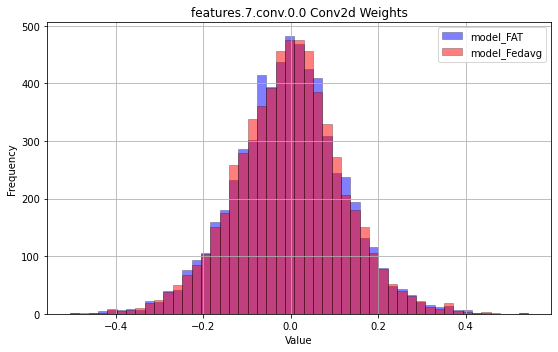

features.7.conv.0.0 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.994162
features.7.conv.0.0 - L2 Norm of Weight Difference (FAT vs Overfit): 0.033425
features.7.conv.0.0 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.992288
features.7.conv.0.0 - Weight Dimensions: torch.Size([192, 32, 1, 1])


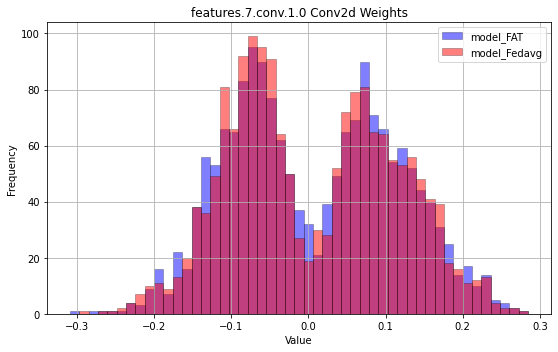

features.7.conv.1.0 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.764590
features.7.conv.1.0 - L2 Norm of Weight Difference (FAT vs Overfit): 0.023188
features.7.conv.1.0 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.764566
features.7.conv.1.0 - Weight Dimensions: torch.Size([192, 1, 3, 3])


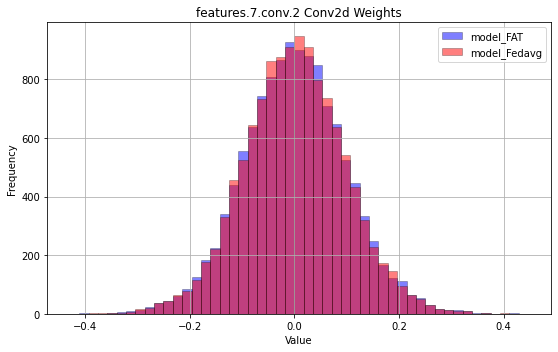

features.7.conv.2 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.990460
features.7.conv.2 - L2 Norm of Weight Difference (FAT vs Overfit): 0.036576
features.7.conv.2 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.988983
features.7.conv.2 - Weight Dimensions: torch.Size([64, 192, 1, 1])


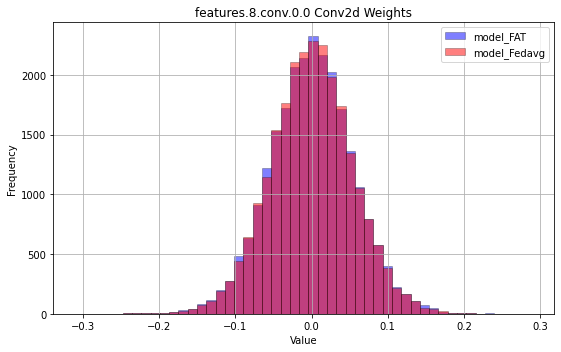

features.8.conv.0.0 - L2 Norm of Weight Difference (FAT vs Fedavg): 1.252698
features.8.conv.0.0 - L2 Norm of Weight Difference (FAT vs Overfit): 0.037108
features.8.conv.0.0 - L2 Norm of Weight Difference (Fedavg vs Overfit): 1.254050
features.8.conv.0.0 - Weight Dimensions: torch.Size([384, 64, 1, 1])


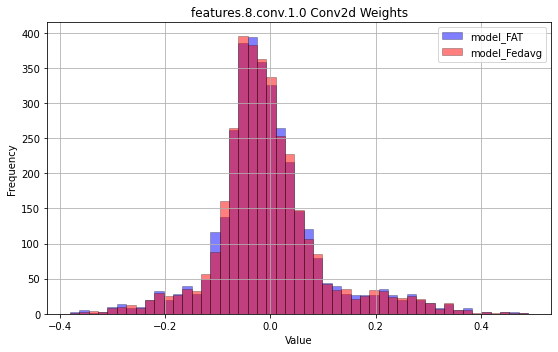

features.8.conv.1.0 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.608320
features.8.conv.1.0 - L2 Norm of Weight Difference (FAT vs Overfit): 0.022636
features.8.conv.1.0 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.607665
features.8.conv.1.0 - Weight Dimensions: torch.Size([384, 1, 3, 3])


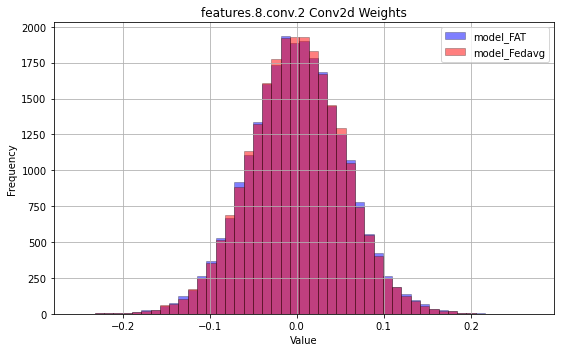

features.8.conv.2 - L2 Norm of Weight Difference (FAT vs Fedavg): 1.098866
features.8.conv.2 - L2 Norm of Weight Difference (FAT vs Overfit): 0.033351
features.8.conv.2 - L2 Norm of Weight Difference (Fedavg vs Overfit): 1.098298
features.8.conv.2 - Weight Dimensions: torch.Size([64, 384, 1, 1])


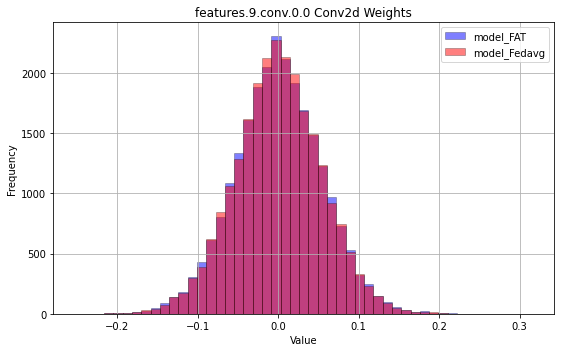

features.9.conv.0.0 - L2 Norm of Weight Difference (FAT vs Fedavg): 1.254439
features.9.conv.0.0 - L2 Norm of Weight Difference (FAT vs Overfit): 0.036922
features.9.conv.0.0 - L2 Norm of Weight Difference (Fedavg vs Overfit): 1.255744
features.9.conv.0.0 - Weight Dimensions: torch.Size([384, 64, 1, 1])


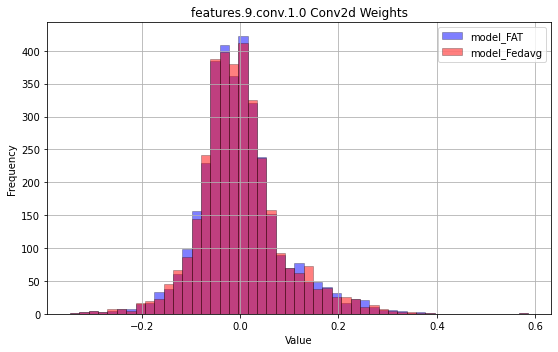

features.9.conv.1.0 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.595757
features.9.conv.1.0 - L2 Norm of Weight Difference (FAT vs Overfit): 0.019949
features.9.conv.1.0 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.595545
features.9.conv.1.0 - Weight Dimensions: torch.Size([384, 1, 3, 3])


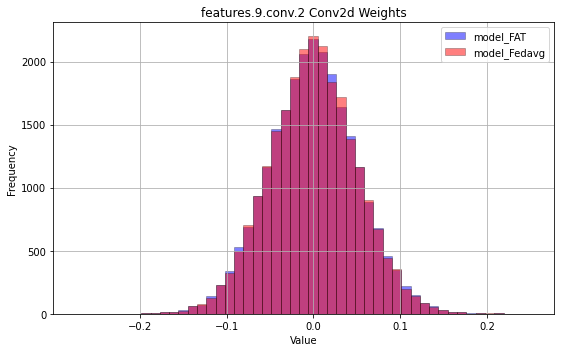

features.9.conv.2 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.965056
features.9.conv.2 - L2 Norm of Weight Difference (FAT vs Overfit): 0.030134
features.9.conv.2 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.965094
features.9.conv.2 - Weight Dimensions: torch.Size([64, 384, 1, 1])


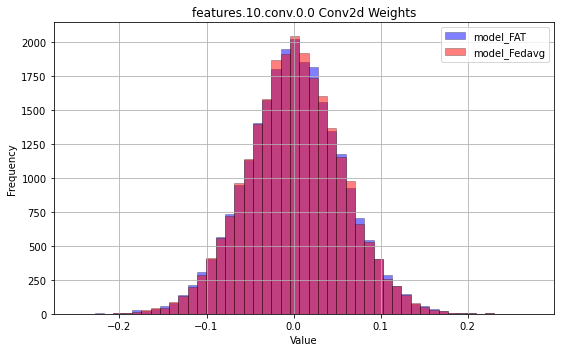

features.10.conv.0.0 - L2 Norm of Weight Difference (FAT vs Fedavg): 1.356144
features.10.conv.0.0 - L2 Norm of Weight Difference (FAT vs Overfit): 0.037704
features.10.conv.0.0 - L2 Norm of Weight Difference (Fedavg vs Overfit): 1.356224
features.10.conv.0.0 - Weight Dimensions: torch.Size([384, 64, 1, 1])


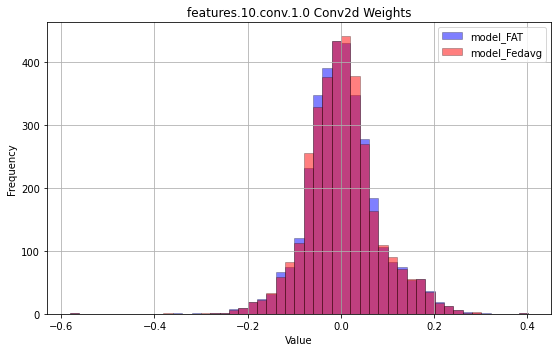

features.10.conv.1.0 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.623549
features.10.conv.1.0 - L2 Norm of Weight Difference (FAT vs Overfit): 0.018991
features.10.conv.1.0 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.622393
features.10.conv.1.0 - Weight Dimensions: torch.Size([384, 1, 3, 3])


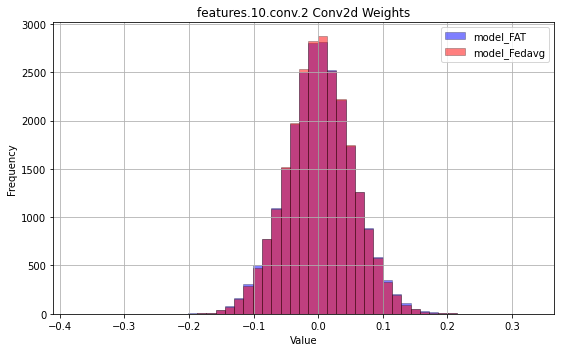

features.10.conv.2 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.983228
features.10.conv.2 - L2 Norm of Weight Difference (FAT vs Overfit): 0.027818
features.10.conv.2 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.983492
features.10.conv.2 - Weight Dimensions: torch.Size([64, 384, 1, 1])


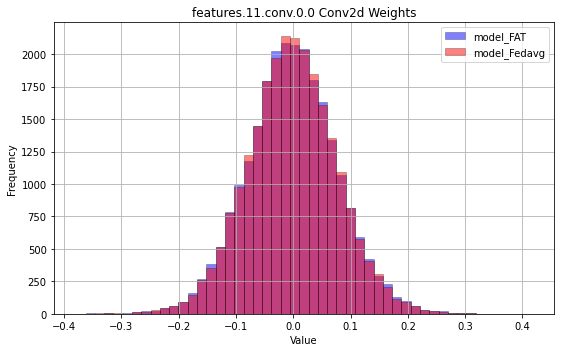

features.11.conv.0.0 - L2 Norm of Weight Difference (FAT vs Fedavg): 1.408695
features.11.conv.0.0 - L2 Norm of Weight Difference (FAT vs Overfit): 0.040485
features.11.conv.0.0 - L2 Norm of Weight Difference (Fedavg vs Overfit): 1.409630
features.11.conv.0.0 - Weight Dimensions: torch.Size([384, 64, 1, 1])


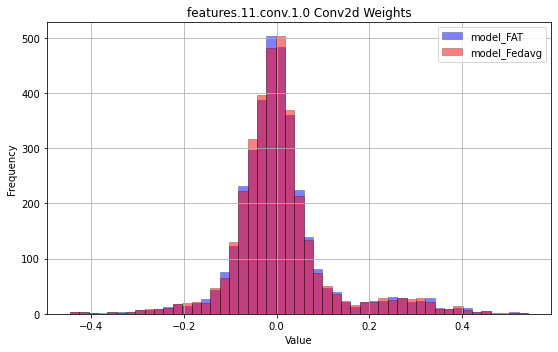

features.11.conv.1.0 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.662451
features.11.conv.1.0 - L2 Norm of Weight Difference (FAT vs Overfit): 0.021344
features.11.conv.1.0 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.662212
features.11.conv.1.0 - Weight Dimensions: torch.Size([384, 1, 3, 3])


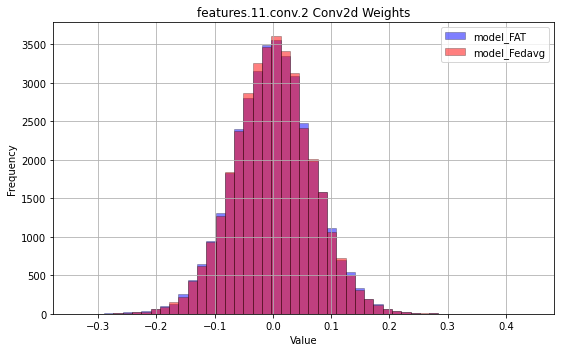

features.11.conv.2 - L2 Norm of Weight Difference (FAT vs Fedavg): 1.279086
features.11.conv.2 - L2 Norm of Weight Difference (FAT vs Overfit): 0.041607
features.11.conv.2 - L2 Norm of Weight Difference (Fedavg vs Overfit): 1.278997
features.11.conv.2 - Weight Dimensions: torch.Size([96, 384, 1, 1])


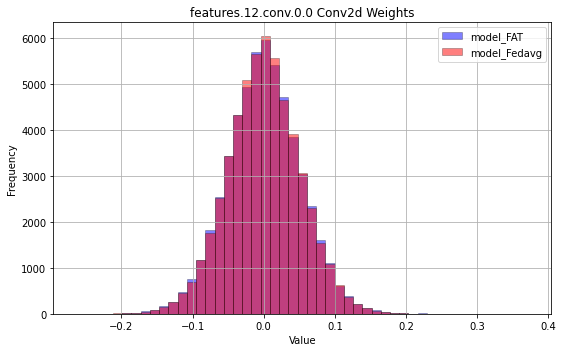

features.12.conv.0.0 - L2 Norm of Weight Difference (FAT vs Fedavg): 1.800574
features.12.conv.0.0 - L2 Norm of Weight Difference (FAT vs Overfit): 0.051583
features.12.conv.0.0 - L2 Norm of Weight Difference (Fedavg vs Overfit): 1.802833
features.12.conv.0.0 - Weight Dimensions: torch.Size([576, 96, 1, 1])


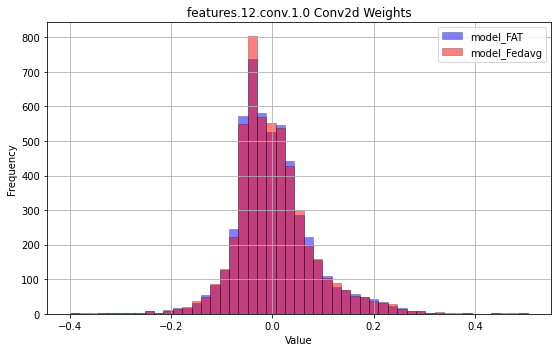

features.12.conv.1.0 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.745297
features.12.conv.1.0 - L2 Norm of Weight Difference (FAT vs Overfit): 0.022666
features.12.conv.1.0 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.746160
features.12.conv.1.0 - Weight Dimensions: torch.Size([576, 1, 3, 3])


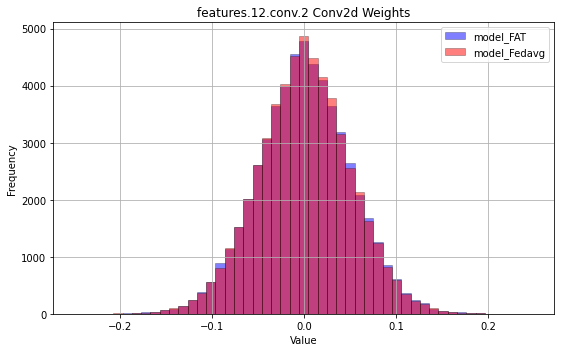

features.12.conv.2 - L2 Norm of Weight Difference (FAT vs Fedavg): 1.372526
features.12.conv.2 - L2 Norm of Weight Difference (FAT vs Overfit): 0.037904
features.12.conv.2 - L2 Norm of Weight Difference (Fedavg vs Overfit): 1.372621
features.12.conv.2 - Weight Dimensions: torch.Size([96, 576, 1, 1])


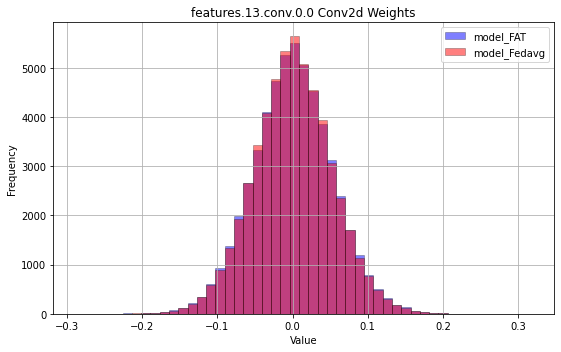

features.13.conv.0.0 - L2 Norm of Weight Difference (FAT vs Fedavg): 1.736545
features.13.conv.0.0 - L2 Norm of Weight Difference (FAT vs Overfit): 0.044853
features.13.conv.0.0 - L2 Norm of Weight Difference (Fedavg vs Overfit): 1.736810
features.13.conv.0.0 - Weight Dimensions: torch.Size([576, 96, 1, 1])


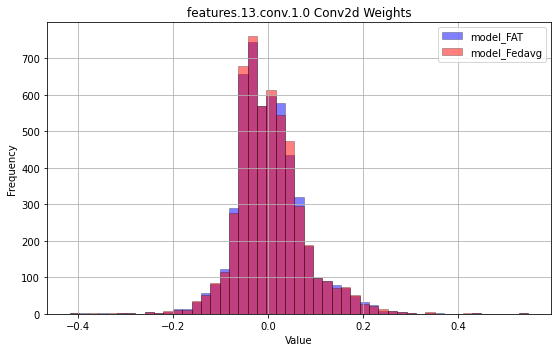

features.13.conv.1.0 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.693777
features.13.conv.1.0 - L2 Norm of Weight Difference (FAT vs Overfit): 0.017518
features.13.conv.1.0 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.693787
features.13.conv.1.0 - Weight Dimensions: torch.Size([576, 1, 3, 3])


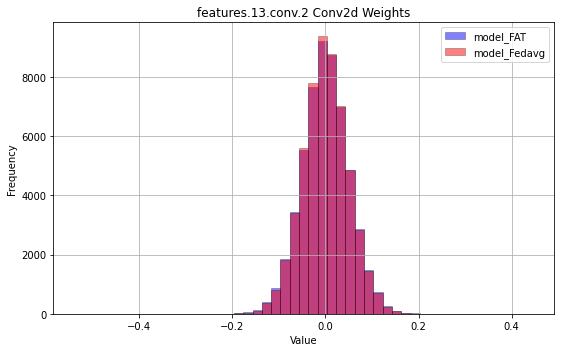

features.13.conv.2 - L2 Norm of Weight Difference (FAT vs Fedavg): 1.244454
features.13.conv.2 - L2 Norm of Weight Difference (FAT vs Overfit): 0.033818
features.13.conv.2 - L2 Norm of Weight Difference (Fedavg vs Overfit): 1.245207
features.13.conv.2 - Weight Dimensions: torch.Size([96, 576, 1, 1])


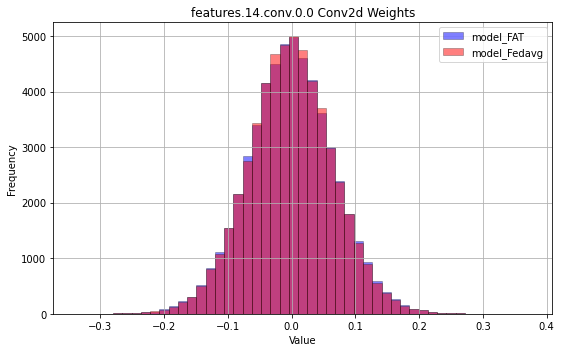

features.14.conv.0.0 - L2 Norm of Weight Difference (FAT vs Fedavg): 1.505434
features.14.conv.0.0 - L2 Norm of Weight Difference (FAT vs Overfit): 0.039798
features.14.conv.0.0 - L2 Norm of Weight Difference (Fedavg vs Overfit): 1.505778
features.14.conv.0.0 - Weight Dimensions: torch.Size([576, 96, 1, 1])


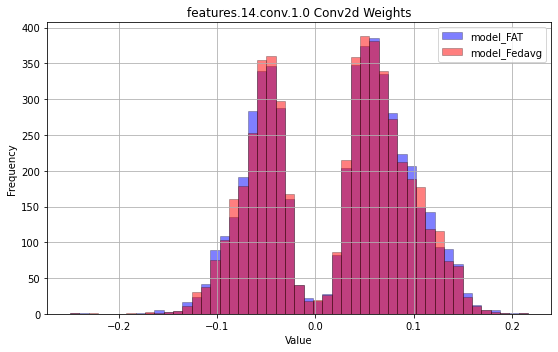

features.14.conv.1.0 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.598783
features.14.conv.1.0 - L2 Norm of Weight Difference (FAT vs Overfit): 0.016674
features.14.conv.1.0 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.598835
features.14.conv.1.0 - Weight Dimensions: torch.Size([576, 1, 3, 3])


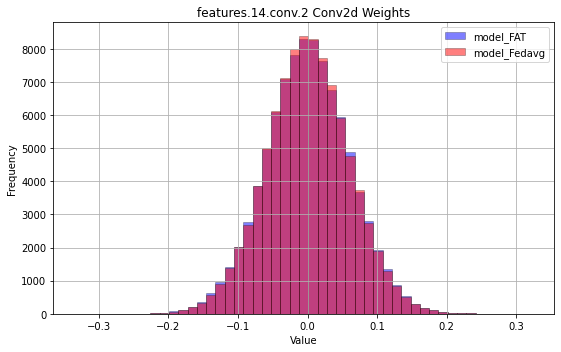

features.14.conv.2 - L2 Norm of Weight Difference (FAT vs Fedavg): 1.264208
features.14.conv.2 - L2 Norm of Weight Difference (FAT vs Overfit): 0.047056
features.14.conv.2 - L2 Norm of Weight Difference (Fedavg vs Overfit): 1.262907
features.14.conv.2 - Weight Dimensions: torch.Size([160, 576, 1, 1])


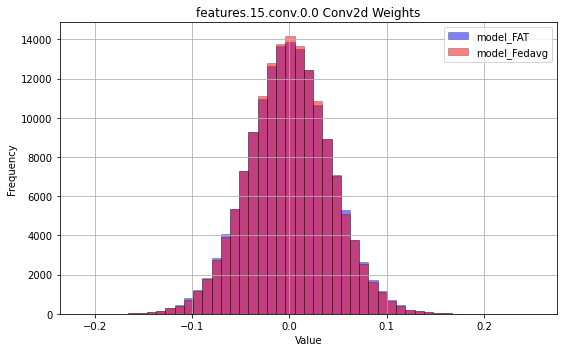

features.15.conv.0.0 - L2 Norm of Weight Difference (FAT vs Fedavg): 1.394728
features.15.conv.0.0 - L2 Norm of Weight Difference (FAT vs Overfit): 0.039860
features.15.conv.0.0 - L2 Norm of Weight Difference (Fedavg vs Overfit): 1.394985
features.15.conv.0.0 - Weight Dimensions: torch.Size([960, 160, 1, 1])


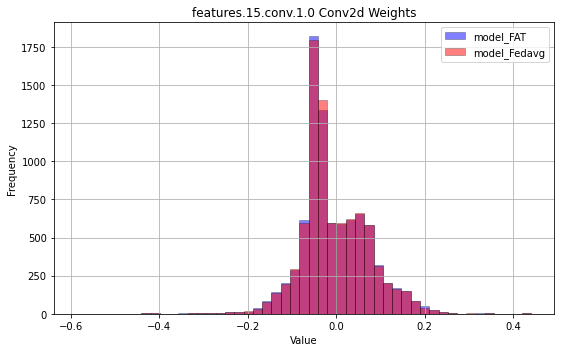

features.15.conv.1.0 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.308209
features.15.conv.1.0 - L2 Norm of Weight Difference (FAT vs Overfit): 0.012692
features.15.conv.1.0 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.306961
features.15.conv.1.0 - Weight Dimensions: torch.Size([960, 1, 3, 3])


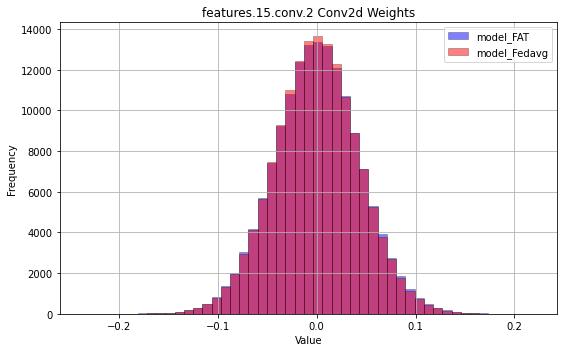

features.15.conv.2 - L2 Norm of Weight Difference (FAT vs Fedavg): 1.006305
features.15.conv.2 - L2 Norm of Weight Difference (FAT vs Overfit): 0.037261
features.15.conv.2 - L2 Norm of Weight Difference (Fedavg vs Overfit): 1.005176
features.15.conv.2 - Weight Dimensions: torch.Size([160, 960, 1, 1])


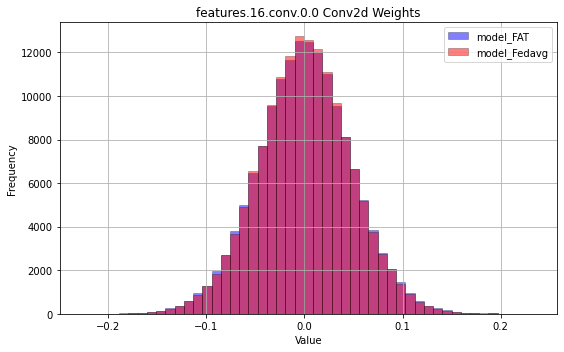

features.16.conv.0.0 - L2 Norm of Weight Difference (FAT vs Fedavg): 1.234710
features.16.conv.0.0 - L2 Norm of Weight Difference (FAT vs Overfit): 0.044229
features.16.conv.0.0 - L2 Norm of Weight Difference (Fedavg vs Overfit): 1.232906
features.16.conv.0.0 - Weight Dimensions: torch.Size([960, 160, 1, 1])


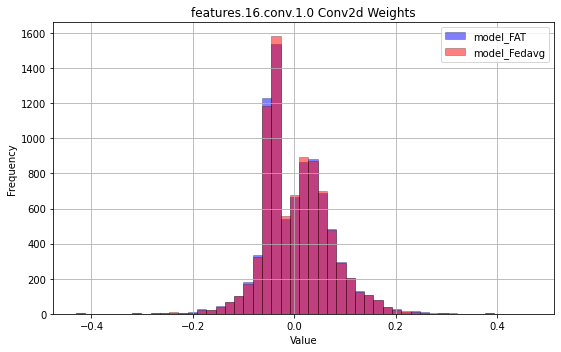

features.16.conv.1.0 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.263815
features.16.conv.1.0 - L2 Norm of Weight Difference (FAT vs Overfit): 0.015201
features.16.conv.1.0 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.261673
features.16.conv.1.0 - Weight Dimensions: torch.Size([960, 1, 3, 3])


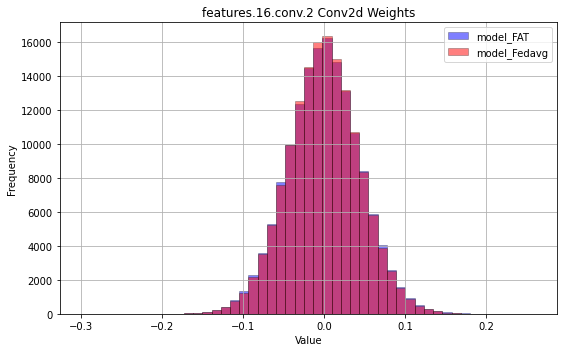

features.16.conv.2 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.917851
features.16.conv.2 - L2 Norm of Weight Difference (FAT vs Overfit): 0.044727
features.16.conv.2 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.913966
features.16.conv.2 - Weight Dimensions: torch.Size([160, 960, 1, 1])


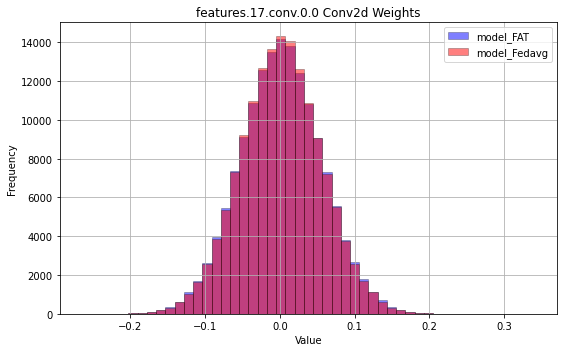

features.17.conv.0.0 - L2 Norm of Weight Difference (FAT vs Fedavg): 1.243903
features.17.conv.0.0 - L2 Norm of Weight Difference (FAT vs Overfit): 0.067942
features.17.conv.0.0 - L2 Norm of Weight Difference (Fedavg vs Overfit): 1.239590
features.17.conv.0.0 - Weight Dimensions: torch.Size([960, 160, 1, 1])


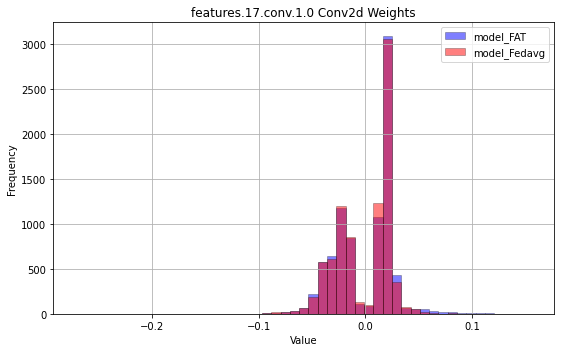

features.17.conv.1.0 - L2 Norm of Weight Difference (FAT vs Fedavg): 0.635630
features.17.conv.1.0 - L2 Norm of Weight Difference (FAT vs Overfit): 0.043661
features.17.conv.1.0 - L2 Norm of Weight Difference (Fedavg vs Overfit): 0.621340
features.17.conv.1.0 - Weight Dimensions: torch.Size([960, 1, 3, 3])


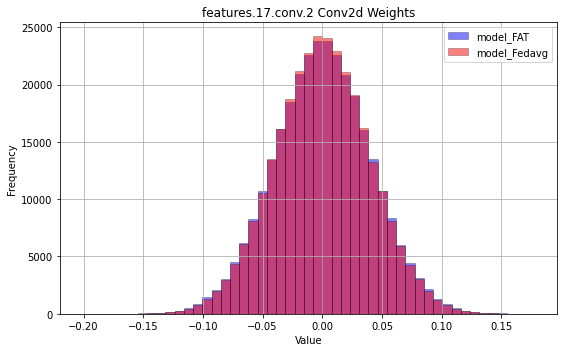

features.17.conv.2 - L2 Norm of Weight Difference (FAT vs Fedavg): 1.058398
features.17.conv.2 - L2 Norm of Weight Difference (FAT vs Overfit): 0.060126
features.17.conv.2 - L2 Norm of Weight Difference (Fedavg vs Overfit): 1.052727
features.17.conv.2 - Weight Dimensions: torch.Size([320, 960, 1, 1])


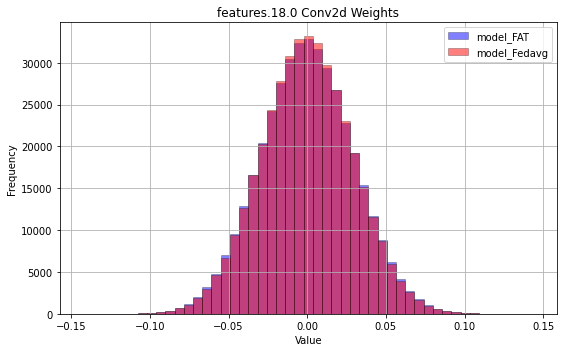

features.18.0 - L2 Norm of Weight Difference (FAT vs Fedavg): 1.077765
features.18.0 - L2 Norm of Weight Difference (FAT vs Overfit): 0.056161
features.18.0 - L2 Norm of Weight Difference (Fedavg vs Overfit): 1.071409
features.18.0 - Weight Dimensions: torch.Size([1280, 320, 1, 1])


In [9]:
# Plot convolution layers difference 
# Toggle options for which models to plot
show_FAT = True
show_Fedavg = True
show_Overfit = False

def get_submodule_by_name(model, name):
    submodule = model
    for part in name.split('.'):
        submodule = getattr(submodule, part)
    return submodule

# Iterate through convolutional layers in model_FAT
for name, module in model_FAT.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        # Extract parameters for model_FAT
        conv_weights_FAT = module.weight.data.cpu().numpy().flatten()
        conv_biases_FAT = module.bias.data.cpu().numpy().flatten() if module.bias is not None else None

        # Extract parameters for model_Fedavg
        module_Fedavg = get_submodule_by_name(model_Fedavg, name)
        conv_weights_Fedavg = module_Fedavg.weight.data.cpu().numpy().flatten()
        conv_biases_Fedavg = module_Fedavg.bias.data.cpu().numpy().flatten() if module_Fedavg.bias is not None else None

        # Extract parameters for model_overfit
        module_overfit = get_submodule_by_name(model_overfit, name)
        conv_weights_overfit = module_overfit.weight.data.cpu().numpy().flatten()
        conv_biases_overfit = module_overfit.bias.data.cpu().numpy().flatten() if module_overfit.bias is not None else None

        # Compute common bin edges for weights and biases
        weights_min = min(np.min(conv_weights_FAT), np.min(conv_weights_Fedavg), np.min(conv_weights_overfit))
        weights_max = max(np.max(conv_weights_FAT), np.max(conv_weights_Fedavg), np.max(conv_weights_overfit))
        bins_weights = np.linspace(weights_min, weights_max, 50)

        if conv_biases_FAT is not None:  # Only compute bins for biases if they exist
            biases_min = min(np.min(conv_biases_FAT), np.min(conv_biases_Fedavg), np.min(conv_biases_overfit))
            biases_max = max(np.max(conv_biases_FAT), np.max(conv_biases_Fedavg), np.max(conv_biases_overfit))
            bins_biases = np.linspace(biases_min, biases_max, 50)

        # Plot histograms for weights
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        if show_FAT:
            plt.hist(conv_weights_FAT, bins=bins_weights, color='blue', alpha=0.5, label='model_FAT', edgecolor='black', linewidth=0.5)
        if show_Fedavg:
            plt.hist(conv_weights_Fedavg, bins=bins_weights, color='red', alpha=0.5, label='model_Fedavg', edgecolor='black', linewidth=0.5)
        if show_Overfit:
            plt.hist(conv_weights_overfit, bins=bins_weights, color='green', alpha=0.5, label='model_overfit', edgecolor='black', linewidth=0.5)
        plt.title(f'{name} Conv2d Weights')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True)

        # Plot histograms for biases
        if conv_biases_FAT is not None:
            plt.subplot(1, 2, 2)
            if show_FAT:
                plt.hist(conv_biases_FAT, bins=bins_biases, color='blue', alpha=0.5, label='model_FAT', edgecolor='black', linewidth=0.5)
            if show_Fedavg:
                plt.hist(conv_biases_Fedavg, bins=bins_biases, color='red', alpha=0.5, label='model_Fedavg', edgecolor='black', linewidth=0.5)
            if show_Overfit:
                plt.hist(conv_biases_overfit, bins=bins_biases, color='green', alpha=0.5, label='model_overfit', edgecolor='black', linewidth=0.5)
            plt.title(f'{name} Conv2d Biases')
            plt.xlabel('Value')
            plt.ylabel('Frequency')
            plt.legend()
            plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Compute L2 norms of differences for weights
        weight_diff_norm_FAT_Fedavg = np.linalg.norm(conv_weights_FAT - conv_weights_Fedavg)
        weight_diff_norm_FAT_Overfit = np.linalg.norm(conv_weights_FAT - conv_weights_overfit)
        weight_diff_norm_Fedavg_Overfit = np.linalg.norm(conv_weights_Fedavg - conv_weights_overfit)

        # Print weight differences and dimensions
        print(f"{name} - L2 Norm of Weight Difference (FAT vs Fedavg): {weight_diff_norm_FAT_Fedavg:.6f}")
        print(f"{name} - L2 Norm of Weight Difference (FAT vs Overfit): {weight_diff_norm_FAT_Overfit:.6f}")
        print(f"{name} - L2 Norm of Weight Difference (Fedavg vs Overfit): {weight_diff_norm_Fedavg_Overfit:.6f}")
        print(f"{name} - Weight Dimensions: {module.weight.data.size()}")

        # Compute L2 norms of differences for biases if they exist
        if conv_biases_FAT is not None:
            bias_diff_norm_FAT_Fedavg = np.linalg.norm(conv_biases_FAT - conv_biases_Fedavg)
            bias_diff_norm_FAT_Overfit = np.linalg.norm(conv_biases_FAT - conv_biases_overfit)
            bias_diff_norm_Fedavg_Overfit = np.linalg.norm(conv_biases_Fedavg - conv_biases_overfit)

            # Print bias differences and dimensions
            print(f"{name} - L2 Norm of Bias Difference (FAT vs Fedavg): {bias_diff_norm_FAT_Fedavg:.6f}")
            print(f"{name} - L2 Norm of Bias Difference (FAT vs Overfit): {bias_diff_norm_FAT_Overfit:.6f}")
            print(f"{name} - L2 Norm of Bias Difference (Fedavg vs Overfit): {bias_diff_norm_Fedavg_Overfit:.6f}")
            print(f"{name} - Bias Dimensions: {module.bias.data.size()}")


In [18]:
# def calc_atk_model_debug(model_inject, model_global, keys, weight_scale, weight_scale_2):
#     with torch.no_grad():
#         atk_model = copy.deepcopy(model_global)
#         inject_state_dict = model_inject.state_dict(keep_vars=False)
#         global_state_dict = model_global.state_dict(keep_vars=False)
#         return_state_dict = atk_model.state_dict(keep_vars=False)
#         total_weight = weight_scale * weight_scale_2

#         for key in keys:
#             diff = inject_state_dict[key].data.clone() - global_state_dict[key].data.clone()
#             return_state_dict[key].data = total_weight * diff + global_state_dict[key].data.clone()

#         atk_model.load_state_dict(return_state_dict)
#         return atk_model

def calc_atk_model_debug(model_inject, model_global, keys, weight_scale, weight_scale_2):

    atk_model = copy.deepcopy(model_inject)
    inject_state_dict = model_inject.state_dict(keep_vars=False)
    global_state_dict = model_global.state_dict(keep_vars=False)
    return_state_dict = atk_model.state_dict(keep_vars=False)
    total_weight = weight_scale * weight_scale_2

    # for key in keys:
    for key in keys:
        print(key, "total")
        diff = inject_state_dict[key].data.clone() - global_state_dict[key].data.clone()
        return_state_dict[key].data = total_weight * diff + global_state_dict[key].data.clone()

    atk_model.load_state_dict(return_state_dict)

    return atk_model

aggregator.load_state(dir_path=save_path_FAT)
aggregator.update_clients()
aggregator.op = None

adv_id = [0]
weight_scale =  1/aggregator.clients_weights # np.ones(aggregator.clients_weights.shape)#
model_global = aggregator.global_learners_ensemble[0].model
model_inject = model_Fedavg
aggregation_op = None
keys = desired_keys

# Based on aggregation methods change weight scale
if aggregation_op in ['median', 'krum', 'median_sublayers']:# == "median" or aggregation_op == "krum":
    weight_scale = np.ones(weight_scale.shape)

# # Give adversarial clients boosted models and train regular clients 1 round
benign_id = list(range(len(aggregator.clients)))

for a_id in adv_id:
    benign_id.remove(a_id)
    temp_atk_model = calc_atk_model_debug(model_inject, model_global, keys, weight_scale[a_id], weight_scale_2)
    aggregator.clients[a_id].learners_ensemble[0].model.cpu()
    del aggregator.clients[a_id].learners_ensemble[0].model
    aggregator.clients[a_id].learners_ensemble[0].model = temp_atk_model
    # del temp_atk_model
    gc.collect()
    torch.cuda.empty_cache()


# for c_id in benign_id:
#     aggregator.clients[c_id].step()

# # Aggregate model and download
# for learner_id, learner in enumerate(aggregator.global_learners_ensemble):
#     learners = [client.learners_ensemble[learner_id] for client in aggregator.clients]
#     if aggregation_op is None:
#         average_learners_inject(learners, learner, weights=aggregator.clients_weights, desired_keys = desired_keys)
#         print("averaging")

features.0.0.weight total
features.0.1.weight total
features.0.1.bias total
features.0.1.running_mean total
features.0.1.running_var total
features.0.1.num_batches_tracked total
features.1.conv.0.0.weight total
features.1.conv.0.1.weight total
features.1.conv.0.1.bias total
features.1.conv.0.1.running_mean total
features.1.conv.0.1.running_var total
features.1.conv.0.1.num_batches_tracked total
features.1.conv.1.weight total
features.1.conv.2.weight total
features.1.conv.2.bias total
features.1.conv.2.running_mean total
features.1.conv.2.running_var total
features.1.conv.2.num_batches_tracked total
features.2.conv.0.0.weight total
features.2.conv.0.1.weight total
features.2.conv.0.1.bias total
features.2.conv.0.1.running_mean total
features.2.conv.0.1.running_var total
features.2.conv.0.1.num_batches_tracked total
features.2.conv.1.0.weight total
features.2.conv.1.1.weight total
features.2.conv.1.1.bias total
features.2.conv.1.1.running_mean total
features.2.conv.1.1.running_var total


In [22]:
a = 0.0088
params_atk = temp_atk_model.state_dict()
# first make the model with empty weights
new_model = copy.deepcopy(model_FAT)
new_model.eval()
new_weight_dict = copy.deepcopy(params_FAT)
for key in new_weight_dict.keys():
    print(key)
    new_weight_dict[key] = a*params_atk[key] + (1-a)*params_FAT[key] 
new_model.load_state_dict(new_weight_dict)



features.0.0.weight
features.0.1.weight
features.0.1.bias
features.0.1.running_mean
features.0.1.running_var
features.0.1.num_batches_tracked
features.1.conv.0.0.weight
features.1.conv.0.1.weight
features.1.conv.0.1.bias
features.1.conv.0.1.running_mean
features.1.conv.0.1.running_var
features.1.conv.0.1.num_batches_tracked
features.1.conv.1.weight
features.1.conv.2.weight
features.1.conv.2.bias
features.1.conv.2.running_mean
features.1.conv.2.running_var
features.1.conv.2.num_batches_tracked
features.2.conv.0.0.weight
features.2.conv.0.1.weight
features.2.conv.0.1.bias
features.2.conv.0.1.running_mean
features.2.conv.0.1.running_var
features.2.conv.0.1.num_batches_tracked
features.2.conv.1.0.weight
features.2.conv.1.1.weight
features.2.conv.1.1.bias
features.2.conv.1.1.running_mean
features.2.conv.1.1.running_var
features.2.conv.1.1.num_batches_tracked
features.2.conv.2.weight
features.2.conv.3.weight
features.2.conv.3.bias
features.2.conv.3.running_mean
features.2.conv.3.running_var


<All keys matched successfully>

In [23]:
weight_scale[a_id]

tensor(113.6804)

In [24]:

model_global = aggregator.global_learners_ensemble[0].model
model_client = aggregator.clients[1].learners_ensemble[0].model

acc, adv_acc = get_adv_acc(aggregator, new_model, eps=eps_attack, step_size = step_size, steps = steps)
print("Test acc: ", np.mean(acc), " (", np.std(acc),") ", "adv acc: ", np.mean(adv_acc)," (", np.std(adv_acc),") ")

Test acc:  0.8528124988079071  ( 0.061459304364800474 )  adv acc:  0.010312500246800482  ( 0.012147370217938346 ) 
